In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats 

In [2]:
data = pd.read_csv('/datasets/games.csv')

<a id='Знакомство с данными и предобработка'></a>
## 1. Знакомство с данными, предобработка и подготовка

In [3]:
#посмотрим на фрагмент набора данных, которым мы располагаем
data.sample(3)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
92,Call of Duty: Advanced Warfare,PS4,2014.0,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M
7025,Mafia,XB,2004.0,Action,0.17,0.05,0.00,0.01,66.0,7.7,M
14779,Akane Iro ni Somaru Saka Parallel,PS2,2008.0,Adventure,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [4]:
pd.concat([data.sample(1) for _ in range(3)])\
    .style\
    .set_caption('Without random_state')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
3559,The Lord of the Rings: The Return of the King,GBA,2003,Action,0.4,0.15,0,0.01,77,8.2,T
8089,Re-Volt,N64,1999,Racing,0.14,0.04,0,0,nan,nan,nan
238,Madden NFL 2005,PS2,2004,Sports,4.18,0.26,0.01,0.08,91,7.9,E


In [5]:
pd.concat([data.sample(1, random_state=0) for _ in range(3)])\
    .reset_index(drop=True)\
    .style\
    .set_caption('With random_state')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Press Your Luck 2010 Edition,DS,2009,Misc,0.18,0,0,0.01,nan,tbd,E
1,Press Your Luck 2010 Edition,DS,2009,Misc,0.18,0,0,0.01,nan,tbd,E
2,Press Your Luck 2010 Edition,DS,2009,Misc,0.18,0,0,0.01,nan,tbd,E


Для начала приведем названия столбцов к нижнему регистру

In [6]:
#передаем в датафрейм новый список индексов, где все наименования колонок приведены к нижнему регистру
data.columns=['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', \
              'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

In [7]:
#снова оцениваем полученный результат
data.sample(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14003,Worms: Ultimate Mayhem,PC,2011.0,Strategy,0.00,0.03,0.0,0.00,66.0,7.8,E10+
5103,Quake 4,X360,2005.0,Shooter,0.32,0.02,0.0,0.03,75.0,6.7,M
11054,Ratchet & Clank Future: Quest for Booty,PS3,2008.0,Platform,0.01,0.06,0.0,0.02,NaN,NaN,NaN


In [8]:
#взглянем на информацию о нашем датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<span style="text-decoration:underline">Промежуточные выводы:</span>

1. В таблице всего 16175 записей и 11 столбцов с данными
2. 5 из 11 столбцов заполнены полностью. В остальных столбцах наблюдаются пропуски
3. В столбце `name` 16713 наблюдений, что меньше общего числа записей в таблице на 2 - это странно, так как наименование игры, следуя логике данных, имеет определяющее значение - фактически, является объектом, атрибуты которого - данные в соседних столбцах. 
4. В столбце `year_of_release` использован тип данных - число с плавающей точкой, что не требуется для такой характеристики как год релиза игры
5. Также в столбце `year_of_release` отсутствует часть значений и иного способа, кроме ручного, либо автоматизированного поиска информации для заполнения значений нет
6. Судя по полученным семплам, число разрядов в столбцах с количеством проданных копий в миллионах недостаточно, поэтому у некоторых тайтлов в качестве продаж используются значения вида 0.00, что может не соответствовать действительности и, скорее всего, может повлиять на корректность значений о распределении продаж по регионам. Однако в свете тайтлов/платформ с десятками/сотнями миллионов продаж, это будет не очень существенно
7. В столбце `genre` приведены данные типа "строка". Судя по контексту, это номинальные качественные данные с довольно ограниченным (в отличие от наименования тайтла) числом значений, поэтому для анализа успеха определенно жанра в различных разрезах имеет смысл проверить столбец на уникальность значений
8. Столбцы с оценками и рейтингом также имеют существенное количество пропусков (иногда порядка 40%). Кроме того, тип данных не позволяет заполнить значения на основании пула имеющихся данных, но и заполнение значений нулями также будет некорректно.
9. В столбце `user_score` у данных использован строковый тип, что требует преобразования к числу         
10. Столбец `rating` похож по своей сути на жанр, но почти наверняка будет содержать еще меньше доступных значений

<span style="text-decoration:underline">Требуется:</span>

1. Проверить 2 "недостающие" записи в столбце `name`
2. Преобразовать тип данных столбца `year_of_release` в целое число
3. Проверить столбец `genre` на предмет уникальности использованных значений (исключить разные варианты написания, ошибки)
4. Проверить значения в столбцах продаж на предмет выбросов (ошибки ввода, обработки и т.п.)
5. Изменить тип данных в столбце `user_score`
6. Проверить значения оценок на предмет выбросов 
7. Проверить столбец `rating` на предмет уникальности использованных значений

In [9]:
#посмотрим, есть ли полные дубликаты в таблице
data.duplicated().value_counts()

False    16715
dtype: int64

In [10]:
#оценив список игровых платформ, мы видим, что дубликатов или некорректного/различного написания нет
data['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

Мы видим, что по количеству выпущенных тайтлов в датасете лидирует компания Sony (ее игровые платформы занимают 1 и 3 строчки).

In [11]:
#отберем две записи из датасета, у которых отсутствует информация о наименовании игры
data.loc[data['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Мы видим, что в датасете есть данные о двух играх для платформы Sega Genesis, вышедших в 1993 году. Следует обратить внимание, что у записи с индексом 659 есть достаточное количество атрибутов, которые:

1. Помогут найти ее название в Интернете вручную
2. Наверняка существенно влияют на общий успех платформы (около 2.3 млн проданных копий)

Поисковый запрос "sega genesis 1993 north america sales 1.78 mln game" возвращает ссылку на страницу с бестселлерами для Sega Genesis, в котором присутствует игра "Mortal Kombat II" (выпущена в апреле 1993 года и разошлась тиражом "как минимум" 1.78 млн копий). 

Держа в уме этот факт, взглянем на пул игр на платформу "GEN" в нашем датасете. 

В списке нет Mortal Kombat II, поэтому мы можем предположить, что запись с недостающим именем - это именно она. 

In [12]:
#присваиваем новое имя игре
data.loc[(data['name'].isnull()) & (data['platform'] == 'GEN') & \
         (data['na_sales'] > 1.7), 'name'] = 'Mortal Kombat II'
#ей же присваиваем новый жанр
data.loc[(data['name'] == 'Mortal Kombat II') & (data['platform'] == 'GEN'), 'genre'] = 'Fighting'

#вторая же строка не представляет для нас большого интереса и будет непросто найти эту игру в сети, поэтому
#от нее мы просто избавимся
data.drop(data.loc[data['name'].isnull()].index, inplace=True) 
data = data.reset_index(drop=True)

In [13]:
#для простоты заполним пустые значения столбца year_of_release значениями, которые явно выходят за разумные границы (например, 1900 год)
#тогда преобразование в тип "целое число" пройдет успешно, а при необходимости оценить данные в разрезе года, мы сможем легко 
#включить в отдельную группу те строки, у которых ранее отсутствовало значение
data['year_of_release'] = data['year_of_release'].fillna(1900)
data['year_of_release'] = data['year_of_release'].astype(int)

In [14]:
#посмотрим на фрагмент датасета
data.sample(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13671,Bloody Roar Extreme,XB,2003,Fighting,0.03,0.01,0.0,0.00,61.0,8.6,T
9336,Rogue Warrior,PS3,2009,Shooter,0.11,0.01,0.0,0.01,27.0,2.8,M
9857,DreamWorks Super Star Kartz,3DS,2011,Racing,0.08,0.03,0.0,0.01,NaN,tbd,E


Теперь нам необходимо оценить корректность указания года релиза для игр по платформам - возможно в данных есть ошибки.

In [15]:
platform_year_check = data.loc[data['year_of_release'] != 1900]\
.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
platform_year_check.columns=['min_year_of_release', 'max_year_of_release']
platform_year_check['life_cycle'] = platform_year_check['max_year_of_release'] - platform_year_check['min_year_of_release']
platform_year_check = platform_year_check.sort_values('life_cycle', ascending=False)
platform_year_check.head(10)

,min_year_of_release,max_year_of_release,life_cycle
platform,,,
PC,1985,2016,31
DS,1985,2013,28
GB,1988,2001,13
X360,2005,2016,11
PSP,2004,2015,11
PS2,2000,2011,11
NES,1983,1994,11
DC,1998,2008,10
Wii,2006,2016,10


Мы видим два значения похожих на аномалию: 

1. PC - персональный компьютер
2. DS - Nintendo DS

Рассматривать значение в 31 год для ПК как аномалию мы не будем, так как ПК как игровую платформу невозможно разделить на явные "дискретные" поколения. Игра, выпущенная 30 лет назад для MS-DOS будет считаться игрой для той же платформы, что и игра выпущенная в 2016 году для Windows 7, несмотря на пропасть в поколении железа. Таким образом платформа PC будет выступать в виде исключения.

DS - это портативная консоль Nintendo DS. По информации из открытых источников, эта консоль стартовала в 2004-2005 году (в зависимости от региона), а ее поддержка была прекращена в 2013 году. Соответственно, 1985 год в качестве минимальной релизной даты нам явно не подходит и необходимо внимательно посмотреть на записи с этим значением. 

In [16]:
#ищем подозрительные строки для платформы DS
data.loc[(data['platform'] == 'DS') & (data['year_of_release'] < 2004) & (data['year_of_release'] != 1900)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15956,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


По информации из сети, эта игра была выпущена в 2010 году. Внесем соответствующие изменения в датасет.

In [17]:
#присваиваем записи новое значение
data.loc[(data['platform'] == 'DS') & (data['year_of_release'] < 2004) & (data['year_of_release'] != 1900), 'year_of_release']\
= 2010
#ошибка исправлена
data.loc[(data['name'] == 'Strongest Tokyo University Shogi DS')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15956,Strongest Tokyo University Shogi DS,DS,2010,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


In [18]:
#Посмотрим, сколько уникальных жанров указано в столбце genre
print('Количество уникальных жанров в датасете:',  len(data['genre'].unique()))

Количество уникальных жанров в датасете: 12


In [19]:
#Теперь оценим, нет ли дубликатов в списке
data['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         850
Strategy         683
Puzzle           580
Name: genre, dtype: int64

Очевидных проблем со списком жанров в датасете нет:

* Жанр указан у всех записей таблицы
* В списке жанров нет дубликатов

In [20]:
#оценим данные по продажам игр
data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].describe()

,na_sales,eu_sales,jp_sales,other_sales
count,16714.000000,16714.000000,16714.000000,16714.000000
mean,0.263393,0.145068,0.077620,0.047345
std,0.813625,0.503352,0.308862,0.186736
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


Явно выделяющихся значений нет. Видна особенность: При максимальных значениях, исчисляемых десятками миллионов, третий квартиль ни в одном из регионов не поднимается выше четверти миллиона проданных копий. 

Из этого можно сделать вывод, что большую часть оборота делают единичные игры - распределение будет смещено вправо (это видно и по разнице между средним и медианным значением). 

Также можно предположить, что платежеспособный спрос сконцентрирован в Северной Америке.

In [21]:
data.loc[data['user_score'].isnull() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16709,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16710,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16711,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16712,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [22]:
#для проверки отберем пул тайтлов, с продажами более 10 млн копий в Северной Америке
#мы видим, что максимальные значения для всех регионов кроме other сосредоточены в этой 21 записи
data.loc[data['na_sales'] > 10]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [23]:
#посмотрим на список уникальных значений столбца user_score
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо пустых значений, в списке присутствует строковое значение "tbd". Остальные значения выглядят как оценки в виде числа с плавающей точкой. Посчитаем общее количество значений в списке, количество пустых ячеек, количество записей со значением "tbd" и количество оценок. 

In [24]:
print('Общее количество ячеек в столбце user_score:', len(data['user_score']))
print('Количество пустых записей в столбце с пользовательскими оценками:', len(data.loc[data['user_score'].isnull()]))
print('Количество записей "tbd" в столбце с пользовательскими оценками:', len(data.loc[data['user_score'] == 'tbd']))
print('Количество пользовательских оценок:', len(data['user_score']) - len(data.loc[data['user_score'].isnull()])\
      - len(data.loc[data['user_score'] == 'tbd']))

Общее количество ячеек в столбце user_score: 16714
Количество пустых записей в столбце с пользовательскими оценками: 6700
Количество записей "tbd" в столбце с пользовательскими оценками: 2424
Количество пользовательских оценок: 7590


Аббревиатура "tbd" расшифровывается как "To Be Determined", что значит "будет определено". Вероятно, пользовательские оценки для тайтлов с данным значением в столбце `user_score` были в процессе подсчета, либо получения из какого-либо внешнего источника. Отсутствие оценки означает, что установить ее мы сможет только путем ручного определения, что очень трудоемко, а в виде простого строкового значения оно ценности для нас не представляет, поэтому его возможности привести к пустой строке.

In [25]:
data['user_score'] = data['user_score'].replace('tbd', np.nan) #заменим значение "tbd" на пустую ячейку
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce') #сделаем преобразование столбца в число

In [26]:
#cмотрим на полученные данные
data[['critic_score', 'user_score']].describe()

,critic_score,user_score
count,8137.000000,7590.000000
mean,68.967679,7.125046
std,13.938165,1.500006
min,13.000000,0.000000
25%,60.000000,6.400000
50%,71.000000,7.500000
75%,79.000000,8.200000
max,98.000000,9.700000


Мы видим, что необычных значений в столбце с оценками нет. 

Можем также обратить внимание на то, что в среднем пользователи склонны выставлять играм более высокие оценки, что объяснимо меньшим уровнем компетентности в вопросах оценки качества игр. Тем не менее, минимально возможное значение зафиксировано в столбце пользовательских оценок, что позволяет нам предположить больший уклон в сторону эмоциональной (субъективной) оценки продуктов в отличие от критиков.

In [27]:
#посмотрим на значения в столбце
data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [28]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

* В столбце с рейтингами присутствуют 8 уникальных значений
* 4 из 8 значений происвоены более чем 1000 разных компьютерных игры
* 4 из 8 значений присвоены менее чем 10 разным тайтлам

Имеет смысл проверить, что означает каждая литера в рейтинге и попытаться понять, есть ли объективная причина малого количества значений.

Поиск позволил установить следующее:

* ESRB (Entertainment Software Rating Board) - система рейтингов, используемая в Северной Америке
    + E - базовый рейтинг. Игра подходит для всех возрастов
    + T - подростковый рейтинг (для детей 13+ лет)
    + M - рейтинг 17+
    + E10+ - рейтинг игр для детей 10 лет и старше
    + EC - раннее детство. Игра предназначена для детей дошкольного возраста
    + RP - рейтинг в ожидании. <span style="text-decoration:underline">Эта комбинация выступает в качестве филлера для игр, рейтинг которым еще не присвоен</span>
    + K-A - рейтинг "Kids to Adults". По смыслу похоже, что рейтинг аналогичен рейтингу E 
    + AO - рейтинг игр "только для взрослых"

<span style="text-decoration:underline">Выводы:</span>

1. Все приведенные значения действительно являются рейтингами
2. Все приведененные рейтинги присваиваются организацией ESRB, действующей в Северной Америке
3. Вероятные причины отсутствия рейтингов: 
    + Игра выпущена до создания организации ESRB (1994 год)
    + В базе ESRB отсутствовали данные о тех тайтлах, которым не присвоен рейтинг в нашем датасете
    + Игра не продавалась на территории Северной Америки официально 
    + Игре был присвоен другой рейтинг (например, другой организацией) и он использовался для продаж
    + Технические проблемы:
        - Ошибка синхронизации данных источника данных для нашего датасета и базы ESRB
        - Ошибка выгрузки
        
В любом случае, заполнить пропуски возможно только поиском точного соответствия игры и рейтинга, присвоенного ей той или иной организацией - использовать текущие значения не представляется возможным.

In [29]:
#еще раз взглянем на сводку о нашем датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
name               16714 non-null object
platform           16714 non-null object
year_of_release    16714 non-null int64
genre              16714 non-null object
na_sales           16714 non-null float64
eu_sales           16714 non-null float64
jp_sales           16714 non-null float64
other_sales        16714 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [30]:
#дополним исходный датасет суммарными продажами по всем регионам
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis='columns')
#оценим результат
data.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
13775,S.Y.K Renshouden Portable,PSP,2011,Adventure,0.00,0.00,0.04,0.00,NaN,NaN,NaN,0.04
11352,Bejeweled 3,PC,2010,Puzzle,0.02,0.05,0.00,0.01,82.0,8.1,E,0.08
13270,Child of Light,PS4,2014,Role-Playing,0.00,0.01,0.04,0.00,82.0,8.0,E10+,0.05
3293,WWE SmackDown vs. Raw 2010,PSP,2009,Fighting,0.25,0.22,0.00,0.14,NaN,6.6,T,0.61
12572,S.T.A.L.K.E.R.: Call of Pripyat,PC,2009,Shooter,0.00,0.05,0.00,0.01,80.0,8.7,M,0.06


1. Мы избавились от 1 значения для игры без конкретного наименования тайтла
2. Привели значение года выпуска к целом числу, переведя NaN в отдельную группу "1900" 
3. Проверили столбцы с категорийными переменными и не обнаружили дублирующих или избыточных значений
4. Значения продаж заполнены данными для всех строк датасета, хотя и содержат нулевые значения, что может повлиять на оценку экономики - это необходимо учитывать при работе с данными
5. Мы привели строковое значение 'tbd' в столбце с пользовательскими оценками к пустому значению, так как по информационной ценности в контексте числовой оценки оно находится на уровне пустой строки
6. Добавили столбец с общим количеством проданных копий во всех регионах

<a href='#Оглавление'> К оглавлению</a>

<a id='Анализ данных'></a>
## 2. Анализ данных

<a id='Количество игр, выпущенных в разные годы'></a>
### 2.1 Количество игр, выпущенных в разные годы

In [31]:
#сформируем небольшой датафрейм через создание сводной таблицы с количеством тайтлов
#исключим из датафрейма тайтлы с годом релиза 1900, которые ранее был присвоен строкам с пропуском в годе релиза
games_per_year = data.loc[data['year_of_release'] != 1900].pivot_table(index='year_of_release', values='name', aggfunc=['count'])
games_per_year = games_per_year.reset_index()
games_per_year.columns=['year_of_release', 'qty_of_titles']
display(games_per_year)

,year_of_release,qty_of_titles
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,13
6,1986,21
7,1987,16
8,1988,15
9,1989,17


In [32]:
print('Доля записей, у которых не указан год релиза: {0:.2f}%'\
      .format(len(data.loc[data['year_of_release'] == 1900]) / len(data.loc[data['year_of_release']]) * 100))

Доля записей, у которых не указан год релиза: 1.61%


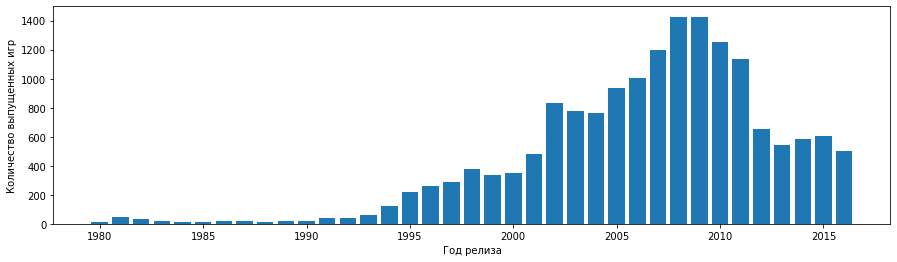

In [33]:
#построим диаграмму для количества выпущенных игр по годам
index = games_per_year['year_of_release']
values = games_per_year['qty_of_titles']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
ax.set_xlabel('Год релиза')
ax.set_ylabel('Количество выпущенных игр')
plt.show()

На диаграмме видны 4 "точки интереса": 

1. Мы видим, что до 1994 года количество выпускаемых игр было небольшим. Далее, в 1994-1995 годах количество удваивалось ежегодно. Вероятно, это связано с выпуском какой-то игровой платформы, либо нового жанра/тайтла. Возможно создание организации ESRB, возрастные рейтинги которой используются в стобце `rating` (1994 год), также связано с этим скачком
2. Далее кривая роста количества проданных игр была практически пологой с плато в период 1998-1999 годов до 2002 года, где снова произошло практически удвоение количества выпускаемых тайтлов с небольшим откатом в 2003-2004. Возможно, это также связано с запуском новой платформы/тайтлов
3. Пиковые значения количества выпускаемых игр для всей выборки лежат на отметках 2008-2009 годов
4. В период 2011-2012 прозошло практически двойное сокращение количества выпускаемых игр. Количество опустилось ниже уровня 2002 года и вплоть до 2016 года находилось примерно на этом же уровне с некоторыми колебаниями в обоих направлениях

Мы можем предположить, что полный объем данных в большей степени важен, если мы ставим перед собой цель проанализовароть развитие игровой индустрии. 

Наибольший интерес для нас представляют события, в результате которых происходили изменения, описанные выше. Более того, события, произошедшие в 21 веке скорее всего в большей степени отражают современные тенденции.

<a href='#Оглавление'> К оглавлению</a>

<a id='Продажи игр в разрезе различных платформ'></a>
### 2.2 Продажи игр в разрезе различных платформ и определение актуального периода

In [34]:
#сформируем таблицу с общим количеством проданных игр и разбивкой по регионам и отсортируем по убыванию количества общих продаж
platform_sales = data.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'], aggfunc='sum')\
.sort_values('total_sales', ascending=False).reset_index()
platform_sales.columns=['platform', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']
platform_sales.head(10)

,platform,na_sales,eu_sales,jp_sales,other_sales,total_sales
0,PS2,339.29,139.20,583.84,193.44,1255.77
1,X360,270.76,12.43,602.47,85.76,971.42
2,PS3,330.29,80.19,393.49,135.68,939.65
3,Wii,262.21,69.33,496.90,79.07,907.51
4,DS,188.89,175.57,382.40,59.26,806.12
5,PS,213.61,139.82,336.52,40.91,730.86
6,GBA,75.25,47.33,187.54,7.73,317.85
7,PS4,141.09,15.96,108.74,48.35,314.14
8,PSP,66.68,76.78,109.17,41.42,294.05
9,PC,142.44,0.17,94.53,22.38,259.52


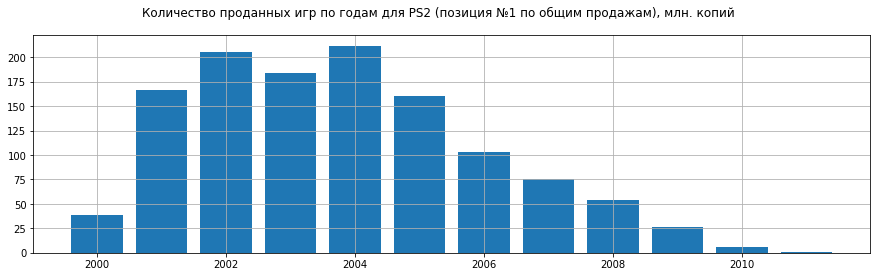

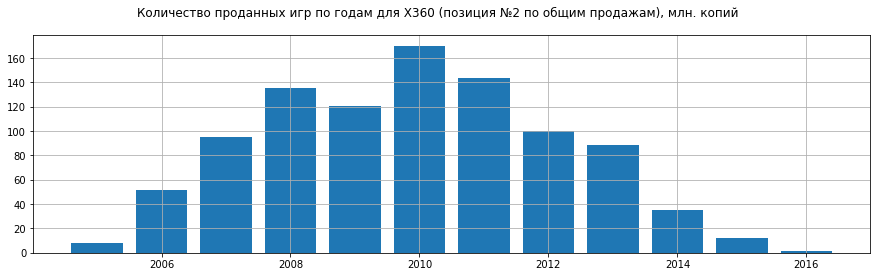

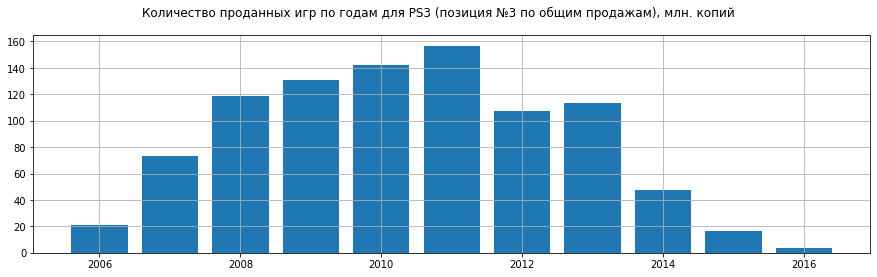

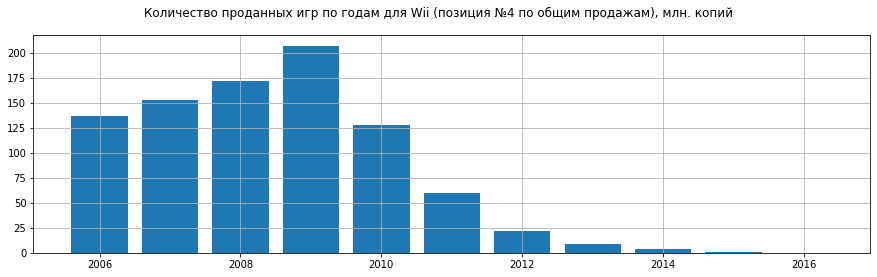

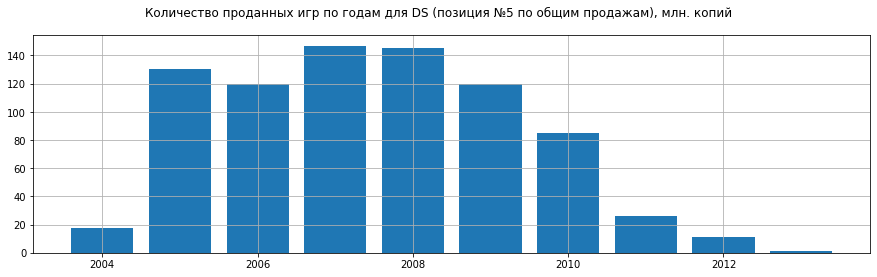

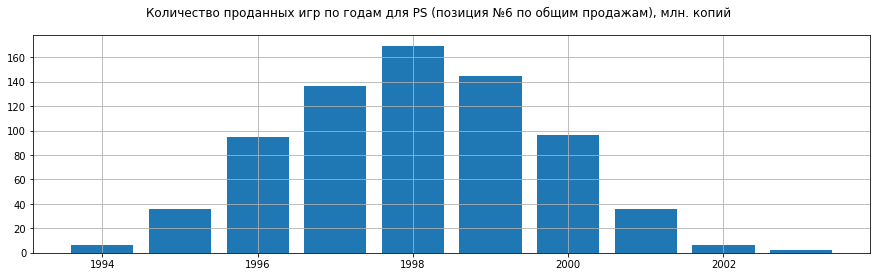

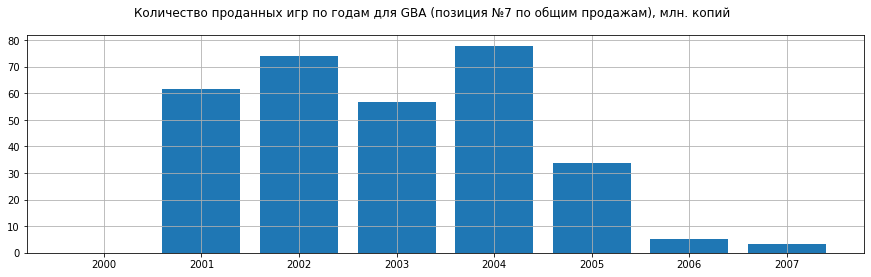

In [35]:
#для построения графика распределения продаж по годам, соберем небольшую таблицу по данным платформы PS2
platform_dist = data.loc[(data['year_of_release'] != 1900) & (data['platform'] == 'PS2')].pivot_table(index='year_of_release',\
                values='total_sales', aggfunc='sum').reset_index().sort_values('year_of_release', ascending=True)

#построим диаграмму для количества выпущенных игр по годам
index = platform_dist['year_of_release']
values = platform_dist['total_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по годам для PS2 (позиция №1 по общим продажам), млн. копий')
ax.grid()
plt.show()

#для построения графика распределения продаж по годам, соберем небольшую таблицу по данным платформы X360
platform_dist = data.loc[(data['year_of_release'] != 1900) & (data['platform'] == 'X360')].pivot_table(index='year_of_release',\
                values='total_sales', aggfunc='sum').reset_index().sort_values('year_of_release', ascending=True)

#построим диаграмму для количества выпущенных игр по годам
index = platform_dist['year_of_release']
values = platform_dist['total_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по годам для X360 (позиция №2 по общим продажам), млн. копий')
ax.grid()
plt.show()

#для построения графика распределения продаж по годам, соберем небольшую таблицу по данным платформы PS3
platform_dist = data.loc[(data['year_of_release'] != 1900) & (data['platform'] == 'PS3')].pivot_table(index='year_of_release',\
                values='total_sales', aggfunc='sum').reset_index().sort_values('year_of_release', ascending=True)

#построим диаграмму для количества выпущенных игр по годам
index = platform_dist['year_of_release']
values = platform_dist['total_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по годам для PS3 (позиция №3 по общим продажам), млн. копий')
ax.grid()
plt.show()

#для построения графика распределения продаж по годам, соберем небольшую таблицу по данным платформы Wii
platform_dist = data.loc[(data['year_of_release'] != 1900) & (data['platform'] == 'Wii')].pivot_table(index='year_of_release',\
                values='total_sales', aggfunc='sum').reset_index().sort_values('year_of_release', ascending=True)

#построим диаграмму для количества выпущенных игр по годам
index = platform_dist['year_of_release']
values = platform_dist['total_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по годам для Wii (позиция №4 по общим продажам), млн. копий')
ax.grid()
plt.show()

#для построения графика распределения продаж по годам, соберем небольшую таблицу по данным платформы DS
platform_dist = data.loc[(data['year_of_release'] != 1900) & (data['platform'] == 'DS')].pivot_table(index='year_of_release',\
                values='total_sales', aggfunc='sum').reset_index().sort_values('year_of_release', ascending=True)

#построим диаграмму для количества выпущенных игр по годам
index = platform_dist['year_of_release']
values = platform_dist['total_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по годам для DS (позиция №5 по общим продажам), млн. копий')
ax.grid()
plt.show()

#для построения графика распределения продаж по годам, соберем небольшую таблицу по данным платформы PS
platform_dist = data.loc[(data['year_of_release'] != 1900) & (data['platform'] == 'PS')].pivot_table(index='year_of_release',\
                values='total_sales', aggfunc='sum').reset_index().sort_values('year_of_release', ascending=True)

#построим диаграмму для количества выпущенных игр по годам
index = platform_dist['year_of_release']
values = platform_dist['total_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по годам для PS (позиция №6 по общим продажам), млн. копий')
ax.grid()
plt.show()

#для построения графика распределения продаж по годам, соберем небольшую таблицу по данным платформы GBA
platform_dist = data.loc[(data['year_of_release'] != 1900) & (data['platform'] == 'GBA')].pivot_table(index='year_of_release',\
                values='total_sales', aggfunc='sum').reset_index().sort_values('year_of_release', ascending=True)

#построим диаграмму для количества выпущенных игр по годам
index = platform_dist['year_of_release']
values = platform_dist['total_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по годам для GBA (позиция №7 по общим продажам), млн. копий')
ax.grid()
plt.show()

Судя по графикам распределения продаж игр по годам для топовых 7 платформ, мы можем сделать следующие выводы: 

1. Полный срок жизни консоли стремится к отметке в районе 10 лет
2. Наиболее "продуктивный" период жизненного цикла 5-7 лет, сосредоточенных вокруг пика (зачастую, 1 пика для всего жизненного цикла)
3. На старте и ближе к концу жизненного цикла консоль пересекается со старым и новым поколением соответственно, что дает некое "оттягивание" части релизов на другую платформу

Во всех случаях, распределение стремится к нормальному. Для платформы Playstation график выглядит практически хрестоматийно. В нашем распоряжении уже имеется таблица `platform_year_check`, которой мы пользовались для определения жизненного цикла каждой платформы и поиска аномалии консоли DS. С ее помощью посчитаем средний срок жизни платформы более точно: 

In [36]:
#мы знаем, что платформа PC имеет долгий жизненный цикл за счет отсутствия явно выраженных поколений, поэтому 31 год для нее - норма
#исключим этот вариант 
platform_year_check.loc[platform_year_check['life_cycle'] != 31, 'life_cycle'].describe()

count    30.000000
mean      6.833333
std       5.583741
min       0.000000
25%       3.000000
50%       6.000000
75%      10.000000
max      28.000000
Name: life_cycle, dtype: float64

Мы видим, что средний жизненный цикл платформы - 6.2 года, что несколько меньше значения, которое мы увидели на графиках с продажами на топовых платформах. 

Однако следует обратить внимание на минимальное время жизни в 0 лет. Это маловероятно для коммерчески успешных платформ, поэтому попробуем взглянуть на "хвост" таблицы. 

In [37]:
platform_year_check.tail(15)

,min_year_of_release,max_year_of_release,life_cycle
platform,,,
N64,1996,2002,6
3DS,2011,2016,5
PSV,2011,2016,5
SAT,1994,1999,5
WiiU,2012,2016,4
GEN,1990,1994,4
NG,1993,1996,3
XOne,2013,2016,3
PS4,2013,2016,3


В 15 записях таблицы с "хвоста" мы видим два типа игровых платформ:

1. Консоли, у которых минимальный год релиза игр приходится на 90е годы при очень коротком жизненном цикле (0-4) года - такие платформы мы классифицируем как "провалы", данные которых нерелевантны для целей исследования
2. Консоли, у которых максимальный год релиза игр совпадает с актуальным на момент выгрузки годом (2016) - это актуальное поколение консолей

Поэтому для определения среднего срока жизни мы избавимся от провалов.

In [38]:
def failed_platforms_search(row): 
    if row['life_cycle'] <= 4 and row['max_year_of_release'] < 2016: #определим явные коммерческие провалы
        row['platform_success'] = 'Коммерческий провал'
    elif row['life_cycle'] > 4 and row['platform'] != 'PC' and row['max_year_of_release'] < 2016: #определим неактуальные платформы
        row['platform_success'] = 'Неактуально'
    elif row['life_cycle'] > 4 and row['life_cycle'] > 8 and row['platform'] != 'PC' and row['max_year_of_release'] == 2016:
        row['platform_success'] = 'Потенциально неактуально'
    else: #определим актуальные платформы
        row['platform_success'] = 'Актуально'
    return row

In [39]:
#повторно используем фрагмент кода для формирования таблицы с расчетов жизненного цикла платформ с учетом исправления
#которое мы внесли во время предобработки
platform_year_check = data.loc[data['year_of_release'] != 1900]\
.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
platform_year_check.columns=['min_year_of_release', 'max_year_of_release']
platform_year_check['life_cycle'] = platform_year_check['max_year_of_release'] - platform_year_check['min_year_of_release']
platform_year_check = platform_year_check.sort_values('life_cycle', ascending=False)

platform_year_check = platform_year_check.reset_index()
platform_year_check.apply(failed_platforms_search, axis=1)

,platform,min_year_of_release,max_year_of_release,life_cycle,platform_success
0,PC,1985,2016,31,Актуально
1,GB,1988,2001,13,Неактуально
2,NES,1983,1994,11,Неактуально
3,X360,2005,2016,11,Потенциально неактуально
4,PSP,2004,2015,11,Неактуально
5,PS2,2000,2011,11,Неактуально
6,DC,1998,2008,10,Неактуально
7,Wii,2006,2016,10,Потенциально неактуально
8,PS3,2006,2016,10,Потенциально неактуально
9,2600,1980,1989,9,Неактуально


In [40]:
platform_year_check = platform_year_check.apply(failed_platforms_search, axis=1)
platform_year_check.pivot_table(index='platform_success', values='platform', aggfunc='count')

,platform
platform_success,
Актуально,6
Коммерческий провал,8
Неактуально,14
Потенциально неактуально,3


In [41]:
#теперь скорректируем таблицу для расчета среднего срока жизни платформы, посмотрим на среднее для релевантных записей
platform_year_check.loc[(platform_year_check['platform_success'] == 'Неактуально') | \
                        (platform_year_check['platform_success'] == 'Потенциально неактуально'), 'life_cycle'].describe()

count    17.000000
mean      9.117647
std       2.147160
min       5.000000
25%       8.000000
50%       9.000000
75%      11.000000
max      13.000000
Name: life_cycle, dtype: float64

Мы видим: 

1. Среднее время жизни платформы 9.1 года. Для простоты будем считать, что платформа "живет" 9 лет
2. Стандартное отклонение 2.15 года. Другими словами, около 70% всех платформ живут в диапазоне 7-11 лет

In [42]:
games_per_year = data.loc[data['year_of_release'] != 1900].pivot_table(index='platform', columns='year_of_release',\
                                                                      values='total_sales', aggfunc='sum').fillna(0)

In [43]:
#функиця для расчета "активного" жизненного цикла платформы
#в качестве "активно" цикла используем значение по принципу правила Парето - годы, в которые продано 80 или более процентов
#копий игр
def active_life_cycle_counter(row):
    platform_total_sales = 0 #переменная для записи суммы продаж
    portions = [] #список для хранения доли продаж за каждый год
    active_life_cycle = 0 #переменная для поиска значения равное или большее 80%
    active_life_cycle_c = 0 #счетчик количества "активных" лет
    for i in range (1980, 2017): #перебираем годы для каждой строки
        if row[i] > 0: #если продажи больше нуля, добавляем значение к сумме
            platform_total_sales += row[i]
        else:
            continue
    for i in range (1980, 2017): #далее для каждой строки конвертируем сумму продаж в долю от общих продаж
        if row[i] > 0:
            row[i] = row[i] / platform_total_sales
        else:
            continue
    for i in range (1980, 2017): #далее перебираем значения долей в строке и, если значение большу нуля, добавляем его в список
        if row[i] > 0:
            portions.append(row[i])
    portions = sorted(portions, reverse=True) #чтобы продажи считали не с левого края распределения, а от моды, сортируем список по убыванию
    for portion in portions: #перебираем значения списка, пока не получим суммарную долю равную или больше 80%
        while active_life_cycle < 0.8:
            active_life_cycle += portion
            active_life_cycle_c += 1
        row['active_life_cycle'] = active_life_cycle_c #в новый столбец возвращаем количество записей из списка - это "активные" годы
    return row

In [44]:
#применяем функцию и присоединяем результат расчета к существующей таблице с расчетом жизненного цикла платформы
games_per_year = games_per_year.apply(active_life_cycle_counter, axis=1)
platform_year_check = platform_year_check.join(games_per_year, on='platform')[['platform', 'min_year_of_release', \
'max_year_of_release', 'life_cycle', 'active_life_cycle', 'platform_success']]
platform_year_check['active_life_cycle'] = platform_year_check['active_life_cycle'].astype(int)

In [45]:
platform_year_check

,platform,min_year_of_release,max_year_of_release,life_cycle,active_life_cycle,platform_success
0,PC,1985,2016,31,6,Актуально
1,GB,1988,2001,13,4,Неактуально
2,NES,1983,1994,11,4,Неактуально
3,X360,2005,2016,11,5,Потенциально неактуально
4,PSP,2004,2015,11,5,Неактуально
5,PS2,2000,2011,11,5,Неактуально
6,DC,1998,2008,10,3,Неактуально
7,Wii,2006,2016,10,4,Потенциально неактуально
8,PS3,2006,2016,10,5,Потенциально неактуально
9,2600,1980,1989,9,2,Неактуально


Мы получили таблицу с полный жизненным циклом платформы и ее "активным" жизненным циклом. 

В "подвале" таблицы есть несколько строк, у которых "активный" срок жизни больше общего срока жизни. Это связано с особенностями подсчета: общий срок жизни - это разность между датой самого свежего релиза и самого старого релиза, поэтому идентичные годы дают в результате ноль - это признак "провала" платформы. Но это для нас не принципиально, так как для определения "актуального" периода для текущих платформ мы не будем использовать статистику провальных платформ.

In [46]:
#посмотрим на статистику платформ, которые на являются коммерчискими провалами и, при этом, прошли или почти прошли полный 
#жизненный цикл
platform_year_check.loc[(platform_year_check['platform_success'] == 'Неактуально') | \
                        (platform_year_check['platform_success'] == 'Потенциально неактуально'), 'active_life_cycle'].describe()

count    17.000000
mean      4.058824
std       0.826936
min       2.000000
25%       4.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: active_life_cycle, dtype: float64

In [47]:
platform_year_check.loc[(platform_year_check['platform_success'] == 'Неактуально') | \
                        (platform_year_check['platform_success'] == 'Потенциально неактуально')]

,platform,min_year_of_release,max_year_of_release,life_cycle,active_life_cycle,platform_success
1,GB,1988,2001,13,4,Неактуально
2,NES,1983,1994,11,4,Неактуально
3,X360,2005,2016,11,5,Потенциально неактуально
4,PSP,2004,2015,11,5,Неактуально
5,PS2,2000,2011,11,5,Неактуально
6,DC,1998,2008,10,3,Неактуально
7,Wii,2006,2016,10,4,Потенциально неактуально
8,PS3,2006,2016,10,5,Потенциально неактуально
9,2600,1980,1989,9,2,Неактуально
10,SNES,1990,1999,9,4,Неактуально


In [48]:
platform_year_check.loc[(platform_year_check['platform_success'] == 'Актуально')]

,platform,min_year_of_release,max_year_of_release,life_cycle,active_life_cycle,platform_success
0,PC,1985,2016,31,6,Актуально
18,3DS,2011,2016,5,4,Актуально
19,PSV,2011,2016,5,3,Актуально
20,WiiU,2012,2016,4,3,Актуально
23,PS4,2013,2016,3,3,Актуально
24,XOne,2013,2016,3,3,Актуально


<span style="text-decoration:underline">Выводы:</span>

1. Срок "актуальности" платформы составляет в среднем 4 года
2. Срок "актуальности" платформы колеблется в диапазоне 3-5 лет - вероятно, по истечению этого срока запускается новое поколение консолей и начинается конкуренция между ними за продажи
3. Средний срок жизни платформы - 9 лет
4. Средний срок жизни колеблется в диапазоне 7-11 лет
5. Судя по списку актуальных платформ, мы можем выделить 3, в первую очередь перспективные:
    + PC - как говорилось выше, данная платформа выступает как исключение, так как не делится на четкие поколения, поэтому ее можно рассматривать как актуальную на текущий момент
    + PS4 - текущий срок жизни и "активный" срок жизни равны ("активный" срок меньше среднего значения) = платформа "свежая" и тайтлы для нее активно продаются
    + XOne - аналогично PS4
6. Также можно выделить группу условного второго приоритета: 
    + 3DS - срок "активного" жизненного цикла равен среднему значению и меньше общего срока жизни - вероятно, продажи пересекли рубеж снижения. Кроме того, консоль имеет характерную особенность - она портативная, что тоже может влиять на специфику спроса
    + PSV - аналогично 3DS, за исключеним величины "активного" срока жизни, но он все же попадает в диапазон 3-5 лет, хоть и меньше средних 4 лет
    + WiiU - срок "активного" жизненного цикла меньше общего срока жизни
    
<a href='#Оглавление'> К оглавлению</a>

<div style="border:solid green 2px; padding: 20px"> <b>Отличная работа</b><br>
Раздел получился очень интересным, не хотелось его прерывать комментариями 👍<br>
Интересен факт применения правила Парето, на мой взгляд, ему место там, где данные распределены таким образом, у нас же, ты это отмечал в коммантариях, распределение похоже на нормальное с небольшим правым смещением. То есть для нас, более корректно брать половину жизненного цикла или медиану. Так как результаты для актуальных платформ получились похожи (если сравнивать половину жц и значение согласно правилу Парето) и объяснимы логически, то оставим правило Парето</div> <br>

<a id='Диаграмма ящик с усами'></a>
### 2.3 Диаграмма "ящик с усами"

In [49]:
annual_sales_per_platform = data.loc[data['year_of_release'] != 1900].pivot_table(index='year_of_release',\
                            columns='platform', values='total_sales', aggfunc='sum')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


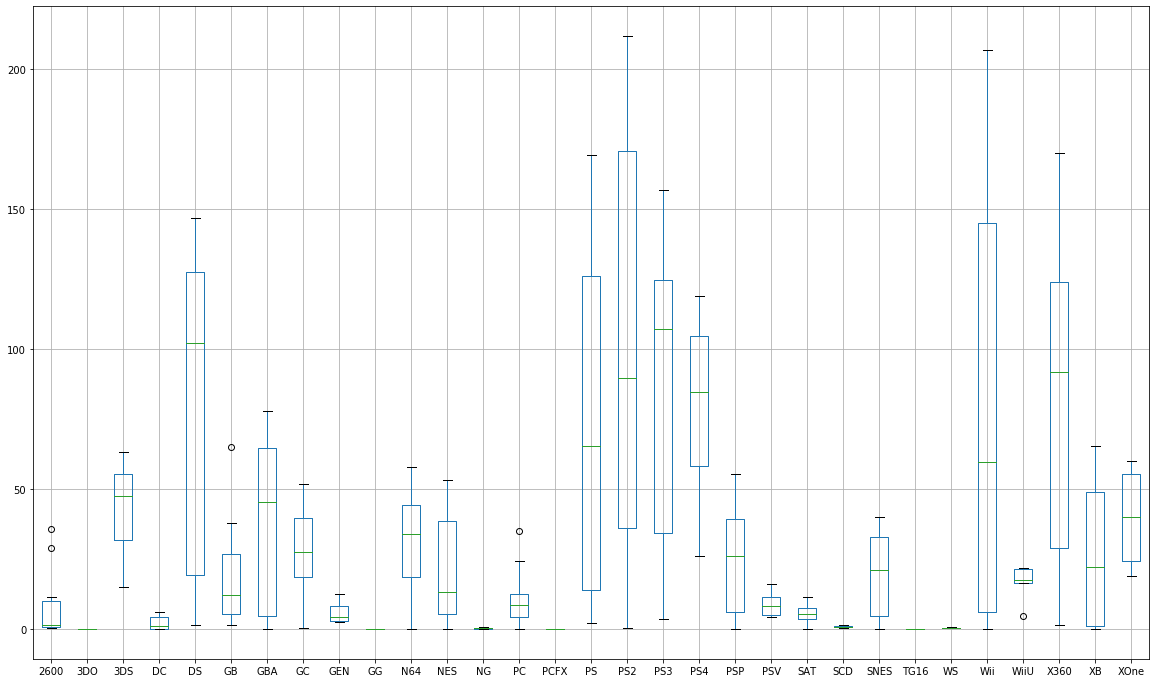

In [50]:
annual_sales_per_platform.plot(kind='box', figsize=(20, 12), grid=True)

Текущий боксплот позволяет оценить общую картину по количеству проданных копий игр в разрезе платформ. График не очень удобно считывать, так как все "ящики" отсортированы по наименованию платформы. Поэтому более разумно перед чтением графика сделать его сортировку. 

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


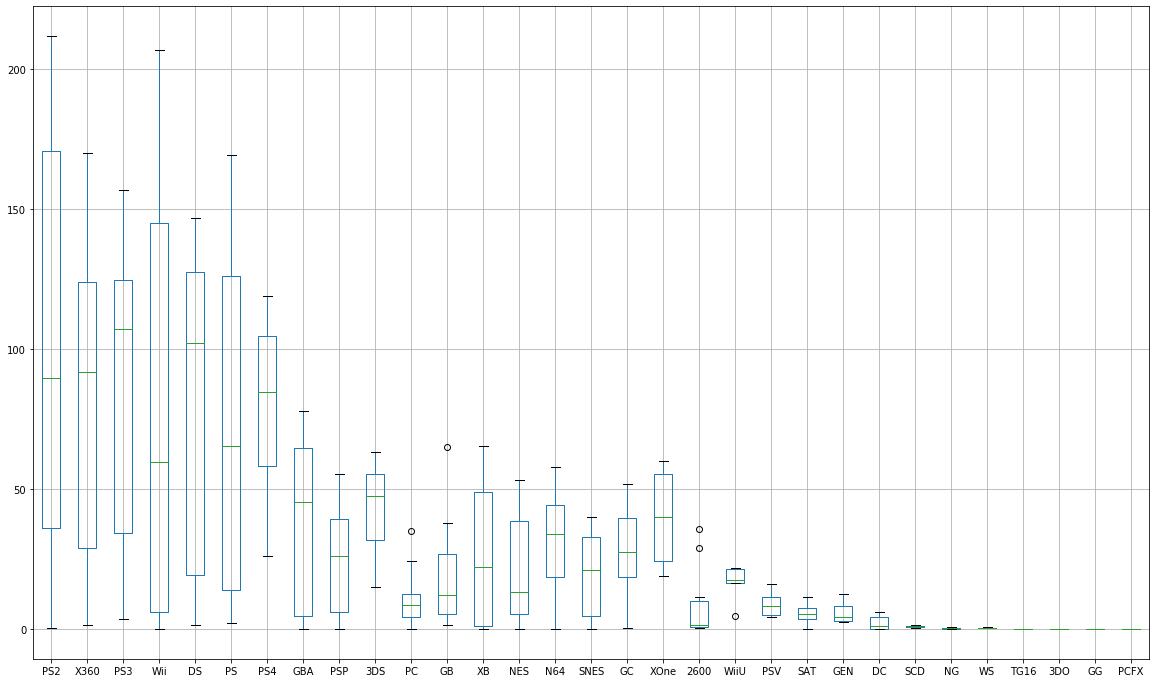

In [51]:
index_sort = annual_sales_per_platform.sum().sort_values(ascending=False).index #считаем сумму по столбцам, сортируем их и забираем индексы
#в отдельный список
annual_sales_per_platform_sorted = annual_sales_per_platform[index_sort] #применяем отсортированные индексы к датафрейму
annual_sales_per_platform_sorted.plot(kind='box', figsize=(20, 12), grid=True) #строим график

<span style="text-decoration:underline">Ящики на графике распределены по убыванию общего объема продаж игр в миллионах копий. На базе графика можно сделать следующие выводы:</span>

1. По межквартильному размаху (нижняя и верхняя границы ящика) мы можем судить о том, насколько сильно "разбросаны" данные по той или иной платформе. В данном случае это косвенно говорит о том, насколько долго продавались игры - чем больше различных значений на временной оси, тем менее плотный интервал между 1 и 3 квартилями
2. Второй интересный момент - это положение среднего и верхней границы ящика: по сочетанию этих двух элементов можно судить о колебаниях уровня продаж: чем дальше друг от друга среднее и верхняя граница "усов", тем больше был всплеск продаж в какой-то из годов по платформе. Например, мы можем предположить, что продажи для PS3 были значительно более "стабильным" в сравненни с продажами Nintendo Wii, несмотря на соседство по общему количеству проданных копий
3. Так как все "ящики" отсортированы в порядке убывания общего количества проданных копий игр, мы можем исключить однозначно исключить PSV и WiiU из списка перспективных платформ, что подтверждает предположение, выдвинутое на основе анализа сроков жизни платформ 
4. Мы знаем, что консоли PS4 и XOne - это актуальные поколения на текущий момент (+PC, но его положение и график в очередной раз подтверждает "исключительность" из-за размытости поколений и, вероятно, каких-то дополнительных факторов). Однако, на графике мы видим, что несмотря на идентичные сроки жизни, PS4 существенно опережает XOne по продажам, что для нас делает это платформу наиболее привлекательной.

Таким образом, список "перспективных" платформ на текущий момент выглядит следующим образом: 

1. PS4
2. XOne
3. PC
4. 3DS

<a href='#Оглавление'> К оглавлению</a>

<div style="border:solid green 2px; padding: 20px"> <b>Отличная работа</b><br>
Тут все классно. Классно, что ты использовал сортировку данных и отключил отображение выбросов на графике - это улучшает визуализацию 🔥</div> <br>

<a id='Анализ зависимости объема продаж от оценок пользователей и критиков'></a>
### 2.4 Анализ зависимости объема продаж от оценок пользователей и критиков

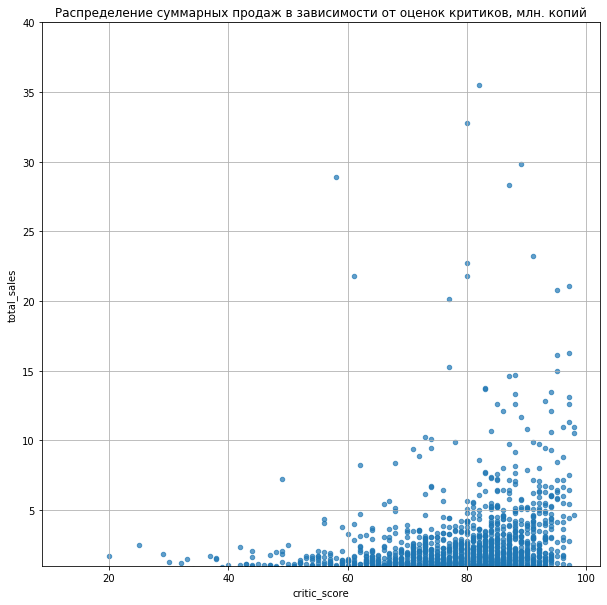

In [52]:
#так как годы в данном случае нас интересует в меньшей степени, для построения графика можем использовать в том числе группу
#с 1900 годом для оценки максимально большого объема данных об оценках критиков
data.plot(alpha=0.7, grid=True, x='critic_score', y='total_sales', style='x', figsize=(10, 10), ylim=(1, 40), kind='scatter',\
title='Распределение суммарных продаж в зависимости от оценок критиков, млн. копий')

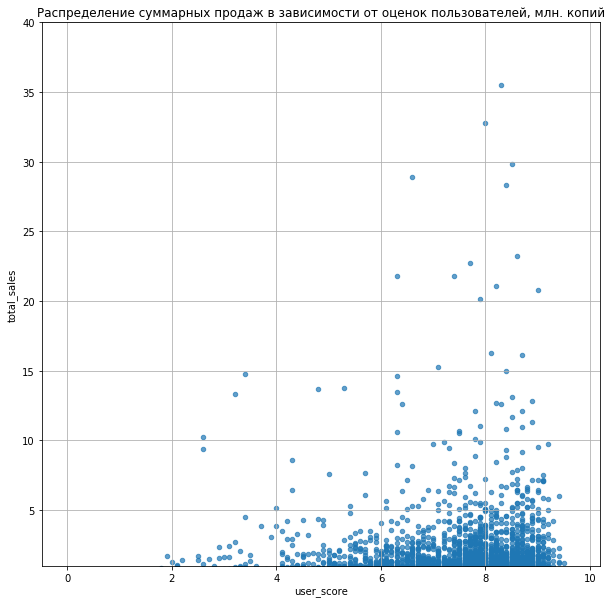

In [53]:
#так как годы в данном случае нас интересует в меньшей степени, для построения графика можем использовать в том числе группу
#с 1900 годом для оценки максимально большого объема данных об оценках критиков
data.plot(alpha=0.7, grid=True, x='user_score', y='total_sales', style='x', figsize=(10, 10), ylim=(1, 40), kind='scatter',\
title='Распределение суммарных продаж в зависимости от оценок пользователей, млн. копий')

Мы видим, что в целом графики для двух типов оценок сопоставимы. Однако есть пара любопытных моментов: 

1. На графике с оценками критикой мы видим, что значения продаж от 5 млн копий стартуют с оценки около 60 баллов; от 10 млн копий и выше для оценок около 80 баллов и выше
2. На графике пользовательских оценок тайтлы с "большими" продажами сильнее распределены по оси оценок: 
    + Редкие значения продаж в диапазоне 5-15 млн копий наблюдаемы даже для оценок в 3-6 баллов, что крайне не характерно для оценок критиков 
    + В диапазоне 6-8 баллов наблюдаемые значения продаж могут чаще превышать отметку в 20 млн копий, а диапазон 10-15 млн копий наполнен значительно большим количеством значений
    + Области графиков от 80 (8) баллов сравнимы для двух графиков 
    
Наиболее вероятно, что пользовательские оценки выставляются играм позже оценок критикой. Предположение основывается на том, что критики могут оценить продукт и выставить ему оценку до релиза игры - вероятно, это может сказать на соответствии восприятия игры пользователя, а значит и ее продажах.

Попробуем построить диаграмму рассеяния для обоих видов оценок.

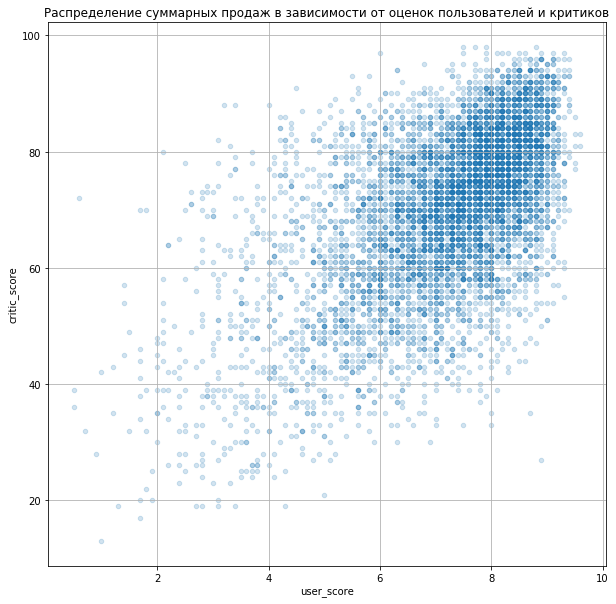

In [54]:
#также построим диаграмму рассеяния для различных оценок
data.plot(alpha=0.2, grid=True, x='user_score', y='critic_score', style='x', figsize=(10, 10), kind='scatter',\
title='Распределение суммарных продаж в зависимости от оценок пользователей и критиков')

Мы видим, плотность соответствия оценок повышается примерно с 60-65 баллов (6-6.5) - график чем-то похож на комету, в хвосте которой увеличивается количество значений (тайтлов) оценки пользователей и критиков для которых существенно расходятся: при этом "левое крыло" (область выше 60 баллов по оценке критиков) визуально немного больше правого. 

Например, мы можем наблюдать относительно большое количество значений в диапазоне критических оценок 60-80 и одновременно пользовательских оценок 2-4 балла. Наблюдаемы также и обратные ситуации. 

Теперь в соответствии с заданием, посмотрим на оценки критиков и пользователей применительно к 1 популярной платформе. Для этого предлагаем использовать не самую актуальную платформу, а ту, у которой будет максимальное количество данных об оценках.

In [55]:
data.loc[data['user_score'] > 0, 'platform'].value_counts().head()

PS2     1241
X360     966
PS3      877
PC       770
XB       586
Name: platform, dtype: int64

Наш выбор - PS2.

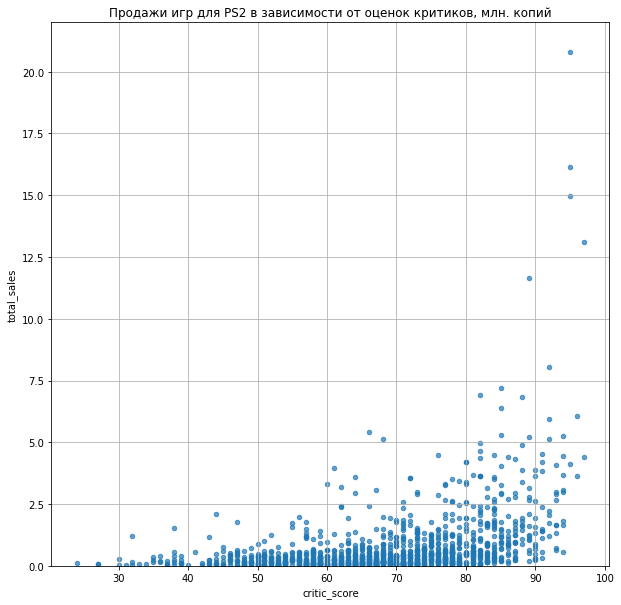

In [56]:
data.loc[data['platform'] == 'PS2'].plot(alpha=0.7, grid=True, x='critic_score', y='total_sales', style='x',\
                                         figsize=(10, 10), ylim=(0, 22), kind='scatter',\
title='Продажи игр для PS2 в зависимости от оценок критиков, млн. копий')

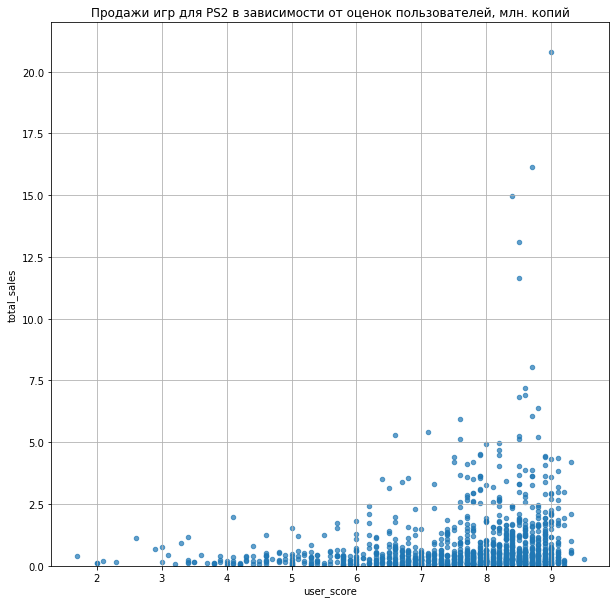

In [57]:
data.loc[data['platform'] == 'PS2'].plot(alpha=0.7, grid=True, x='user_score', y='total_sales', style='x',\
                                         figsize=(10, 10), ylim=(0, 22), kind='scatter',\
title='Продажи игр для PS2 в зависимости от оценок пользователей, млн. копий')

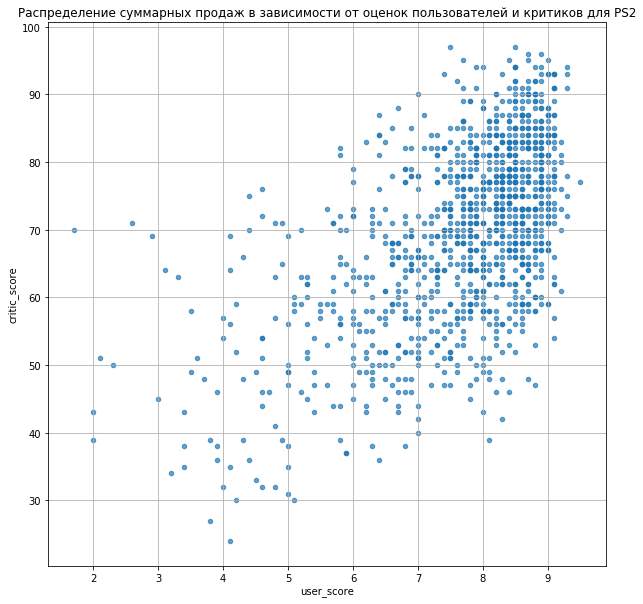

In [58]:
data.loc[data['platform'] == 'PS2'].plot(alpha=0.7, grid=True, x='user_score', y='critic_score', style='x',\
                                         figsize=(10, 10), kind='scatter',\
title='Распределение суммарных продаж в зависимости от оценок пользователей и критиков для PS2')

<span style="text-decoration:underline">Мы видим, что картина для отдельно взятой популярной игровой платформы похожа на общую картину по всем платформам::</span>

1. С ростом оценки увеличивается количество точек на графике, увеличивается продажи игр: до 60 баллов по шкале критиков и до 6 баллов по шкале пользовательских оценок нет тайтлов, чьи продажи превышали бы 2.5 млн проданных копий
2. В диапазоне 60-80% (60-80 баллов по оценкам критиков и 6-8 баллов по оценкам пользователей) довольно много тайтлов с продажами 2.5-5 млн копий. Наблюдается несколько значений в районе 5.5-6 млн копий
3. Все остальные значения продаж (вплоть до 20+ млн проданных копий) лежат в диапазоне 80% млн или более
4. Интересный факт: судя по пожеланию тайтлов-"рекордсменов" на кооординатных плоскостях различных оценок мы можем сделать предположение, что иногда оценки критиков могут быть выше оценок пользователей - возможно речь идет о каких-то проектах с существенными маркетинговыми затратами (в том числе, и на оценки профильных специалистов/изданий)
5. Предположение из п. 4 в том числе находит косвенное подтверждение на диаграмме рассеяния двух типов оценок. Мы видим, что и для этой отдельно взятой платформы существует ряд тайтлов, оценки критиков и пользователей для которых категорически не совпали. 

Судя по диаграммам для PS2 и всех платформ в целом, мы можем предположить, что оценки влияют на продажи игр или, по крайней мере, между этими метриками есть зависимость, но оценки не являются единственным определяющим фактором, влияющим на продажи. 

In [59]:
print('Корреляция между суммарными продажами игр и оценками критиков для всех платформ: {0:.2f}%'\
      .format(data['total_sales'].corr(data['critic_score']) * 100))
print('Корреляция между суммарными продажами игр и оценками пользователей для всех платформ: {0:.2f}%'\
      .format(data['total_sales'].corr(data['user_score']) * 100))

Корреляция между суммарными продажами игр и оценками критиков для всех платформ: 24.55%
Корреляция между суммарными продажами игр и оценками пользователей для всех платформ: 8.82%


In [60]:
print('Корреляция между суммарными продажами игр и оценками критиков для PS2: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'PS2', 'total_sales']\
              .corr(data.loc[data['platform'] == 'PS2', 'critic_score']) * 100))
print('Корреляция между суммарными продажами игр и оценками критиков для PS3: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'PS3', 'total_sales']\
              .corr(data.loc[data['platform'] == 'PS3', 'critic_score']) * 100))
print('Корреляция между суммарными продажами игр и оценками критиков для PS4: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'PS4', 'total_sales']\
              .corr(data.loc[data['platform'] == 'PS4', 'critic_score']) * 100))
print('Корреляция между суммарными продажами игр и оценками критиков для X360: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'X360', 'total_sales']\
              .corr(data.loc[data['platform'] == 'X360', 'critic_score']) * 100))
print('Корреляция между суммарными продажами игр и оценками критиков для XOne: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'XOne', 'total_sales']\
              .corr(data.loc[data['platform'] == 'XOne', 'critic_score']) * 100))

print()

print('Корреляция между суммарными продажами игр и оценками пользователей для PS2: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'PS2', 'total_sales']\
              .corr(data.loc[data['platform'] == 'PS2', 'user_score']) * 100))
print('Корреляция между суммарными продажами игр и оценками пользователей для PS3: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'PS3', 'total_sales']\
              .corr(data.loc[data['platform'] == 'PS3', 'user_score']) * 100))
print('Корреляция между суммарными продажами игр и оценками пользователей для PS4: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'PS4', 'total_sales']\
              .corr(data.loc[data['platform'] == 'PS4', 'user_score']) * 100))
print('Корреляция между суммарными продажами игр и оценками пользователей для X360: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'X360', 'total_sales']\
              .corr(data.loc[data['platform'] == 'X360', 'user_score']) * 100))
print('Корреляция между суммарными продажами игр и оценками пользователей для XOne: {0:.2f}%'\
      .format(data.loc[data['platform'] == 'XOne', 'total_sales']\
              .corr(data.loc[data['platform'] == 'XOne', 'user_score']) * 100))

Корреляция между суммарными продажами игр и оценками критиков для PS2: 39.54%
Корреляция между суммарными продажами игр и оценками критиков для PS3: 43.24%
Корреляция между суммарными продажами игр и оценками критиков для PS4: 40.66%
Корреляция между суммарными продажами игр и оценками критиков для X360: 39.37%
Корреляция между суммарными продажами игр и оценками критиков для XOne: 41.70%

Корреляция между суммарными продажами игр и оценками пользователей для PS2: 17.29%
Корреляция между суммарными продажами игр и оценками пользователей для PS3: 12.67%
Корреляция между суммарными продажами игр и оценками пользователей для PS4: -3.20%
Корреляция между суммарными продажами игр и оценками пользователей для X360: 11.45%
Корреляция между суммарными продажами игр и оценками пользователей для XOne: -6.89%


Мы посчитали корреляцию между суммарными продажами игр и оценками критиков/пользователей для нескольких популярных платформ (в том числе тех, что выше были отнесены к "актуальному" поколению) и видим следующее:

1. Корреляция между оценками критиков и общими продажами есть и находится немного ниже среднего уровня (около 40% для 5 платформ)
2. Корреляция между оценками критиков и общими продажами прямая, то есть чем выше оценка критиков, тем выше продажи игры 
3. Корреляция между оценками пользователей и общими продажами игры также наблюдается, но она ближе к низкому уровню взаимосвязи (10-15%) 
4. Для "актуального" поколения консолей наблюдается интересная особенность: корреляция стала еще слабее, чем была для предыдущих поколений, но при этом появился тренд на обратную зависимость - чем ниже оценка, тем выше продажи. 

На базе этих данных мы можем сделать следующее предположение: **оценки критиков влияют на итоговые продажи игр**, но так как критики выставляют свои оценки значительно раньше пользователей (до релиза), то ожидания пользователей могут быть завышенными и, несмотря на большое количество копий, оценки пользователей могут быть ниже, чем оценки критиков (это видно, в том числе, и на диаграммах рассеяния).

<a href='#Оглавление'> К оглавлению</a>

<a id='Анализ продаж в разрезе жанров'></a>
### 2.5 Выявление популярных жанров

In [61]:
genres_chart = data.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count', 'mean'])
genres_chart.columns=['total_sales', 'number_of_titles', 'mean_sales']
genres_chart.sort_values('total_sales', ascending=False)

,total_sales,number_of_titles,mean_sales
genre,,,
Action,1744.17,3369,0.517711
Sports,1331.27,2348,0.566980
Shooter,1052.45,1323,0.795503
Role-Playing,934.56,1498,0.623872
Platform,827.77,888,0.932173
Misc,802.51,1750,0.458577
Racing,728.67,1249,0.583403
Fighting,449.92,850,0.529318
Simulation,389.97,873,0.446701


In [62]:
genres_chart = data.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count', 'mean'])
genres_chart.columns=['total_sales', 'number_of_titles', 'mean_sales']
genres_chart.sort_values('mean_sales', ascending=False)

,total_sales,number_of_titles,mean_sales
genre,,,
Platform,827.77,888,0.932173
Shooter,1052.45,1323,0.795503
Role-Playing,934.56,1498,0.623872
Racing,728.67,1249,0.583403
Sports,1331.27,2348,0.566980
Fighting,449.92,850,0.529318
Action,1744.17,3369,0.517711
Misc,802.51,1750,0.458577
Simulation,389.97,873,0.446701


По суммарному объему продаж в миллионах копий мы видим первую тройку:
* Action
* Sports 
* Shooter

Однако средние продажи в миллионах копий на 1 тайтл в рамках группы дают нам немного другую картину: 

* Platform
* Shooter 
* Role-Playing

Комбинация этих двух факторов дает нам представление о популярных жанрах, в которых чаще встречаются кассовые хиты: 

* Shooter 
* Platform
* Role-Playing
* Sports 
* Racing

<a href='#Оглавление'> К оглавлению</a>

<a id='Портрет пользователя по регионам'></a>
## 3. Портрет пользователя по регионам

<a id='Регион "Северная Америка"'></a>
### 3.1 Регион "Северная Америка"

In [63]:
#соберем таблицу с продажами игр в Северной Америке с разбивкой по платформам
na_popular_platforms = data.pivot_table(index='platform', values='na_sales', aggfunc='sum')
#присоединим к ней ранее сформированную таблицу с текущим статусом платформы
na_popular_platforms = platform_year_check.join(na_popular_platforms, on='platform')\
[['platform', 'na_sales', 'platform_success', 'min_year_of_release', 'max_year_of_release']]
#отсортируем значения по убыванию количества проданных копий игр
na_popular_platforms = na_popular_platforms.sort_values('na_sales', ascending=False)
na_popular_platforms.head()

,platform,na_sales,platform_success,min_year_of_release,max_year_of_release
3,X360,602.47,Потенциально неактуально,2005,2016
5,PS2,583.84,Неактуально,2000,2011
7,Wii,496.90,Потенциально неактуально,2006,2016
8,PS3,393.49,Потенциально неактуально,2006,2016
12,DS,382.40,Неактуально,2004,2013


Мы видим, что все платформы из топ 5 либо уже неактуальны, либо перестанут быть таковыми в ближайшем будущем. Однако мы видим, что платформа X360 находится на верхней строчке рейтинга со значительным отрывов в количестве проданных игр от PS3 и Wii. Так как X360 - это платформа американской компании, мы можем сделать предположение, что в этом регионе у X360 наиболее агрессивная маркетинговая политика, что дало закономерный результат. 

Посмотрим на топ 5 актуальных платформ. 

In [64]:
na_popular_platforms.loc[na_popular_platforms['platform_success'] ==  'Актуально'].head()

,platform,na_sales,platform_success,min_year_of_release,max_year_of_release
23,PS4,108.74,Актуально,2013,2016
0,PC,94.53,Актуально,1985,2016
24,XOne,93.12,Актуально,2013,2016
18,3DS,83.49,Актуально,2011,2016
20,WiiU,38.10,Актуально,2012,2016


Мы видим, что в текущем поколении наиболее популярная платформа PS4, однако необходимо делать поправку на то, что PC и XOne - фактически, игровые платформы одной компании. 

Также весьма популярна портативная платформа Nintendo 3DS, уступая порядка 25 млн копий проданных игр лидеру и около 10 млн платформе XOne. 

А вот WiiU хоть и входит в топ 5, почти в два с половиной-три раза уступает по количеству проданных копий другим платформам из топа. 

In [65]:
na_popular_genres = data.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False)
na_popular_genres.head()
#получаем top 5 популярных жанров в регионе

,na_sales
genre,
Action,879.01
Sports,684.43
Shooter,592.24
Platform,445.50
Misc,407.27


Возможно, популярность жанра важна в том числе в разрезе различных платформ. Попробуем это понять:

In [66]:
na_genre_sep = data.pivot_table(index='platform', columns='genre', values='na_sales', aggfunc='sum')
na_popular_platforms = na_popular_platforms.join(na_genre_sep, on='platform')
na_popular_platforms.loc[na_popular_platforms['platform_success'] == 'Актуально'].head()

,platform,na_sales,platform_success,min_year_of_release,max_year_of_release,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
23,PS4,108.74,Актуально,2013,2016,32.83,1.95,3.60,3.14,2.45,0.00,2.61,9.34,32.66,0.21,19.78,0.17
0,PC,94.53,Актуально,1985,2016,10.15,1.76,0.10,5.69,0.05,0.09,0.44,17.35,18.81,20.08,0.38,19.63
24,XOne,93.12,Актуально,2013,2016,21.37,1.27,1.65,4.77,0.51,NaN,4.36,6.15,36.86,0.32,15.59,0.27
18,3DS,83.49,Актуально,2011,2016,19.80,1.18,4.46,2.69,13.27,1.30,6.35,23.76,0.66,7.58,1.66,0.78
20,WiiU,38.10,Актуально,2012,2016,9.69,0.07,3.28,5.50,9.94,0.62,3.47,1.06,2.34,0.14,1.50,0.49


Картина действительно немного отличается: 

* Для группы "стационарные консоли" топ 5 в Северной Америке выглядит так: 
    + Shooter
    + Action
    + Sports 
    + Role-Playing
    + Fighting
    
* Для PC этот топ значительно отличается (появляются два абсолютно непопулярных на консолях жанра): 
    + Simulation
    + Strategy
    + Shooter 
    + Role-Playing
    + Action
    
* Для консолей Nintendo топ также отличается (на этих консолях также есть свой "особенный жанр" - платформеры): 
    + Action
    + Platform
    + Role-Playing (для 3DS) 
    + Simulation (для 3DS) 
    + Racing

In [67]:
rating = data.pivot_table(index='rating', values='na_sales', aggfunc='sum').reset_index()\
.sort_values('na_sales', ascending=False)
rating

,rating,na_sales
1,E,1292.99
7,T,759.75
5,M,748.48
2,E10+,353.32
4,K-A,2.56
3,EC,1.53
0,AO,1.26
6,RP,0.00


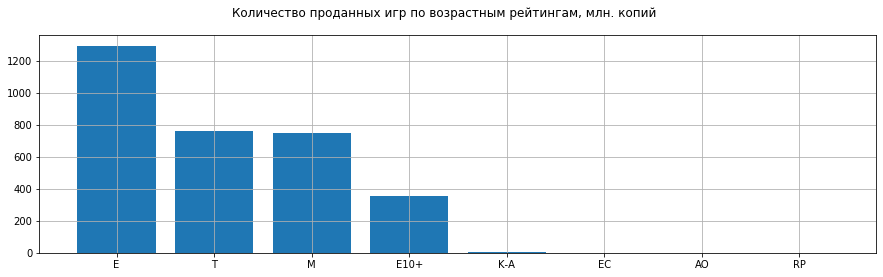

In [68]:
index = rating['rating']
values = rating['na_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по возрастным рейтингам, млн. копий')
ax.grid()
plt.show()

* ESRB (Entertainment Software Rating Board) - система рейтингов, используемая в Северной Америке
    + E - базовый рейтинг. Игра подходит для всех возрастов
    + T - подростковый рейтинг (для детей 13+ лет)
    + M - рейтинг 17+
    + E10+ - рейтинг игр для детей 10 лет и старше
    + EC - раннее детство. Игра предназначена для детей дошкольного возраста
    + RP - рейтинг в ожидании. <span style="text-decoration:underline">Эта комбинация выступает в качестве филлера для игр, рейтинг которым еще не присвоен</span>
    + K-A - рейтинг "Kids to Adults". По смыслу похоже, что рейтинг аналогичен рейтингу E 
    + AO - рейтинг игр "только для взрослых"

Мы видим, что наиболее продаваемые игры имеют рейтинг E, то есть пригодны для всех возрастов. Игры для детей 10 и 13 лет дают еще примерно такое же количество копий, как и игры для всех возрастов. Однако на втором месте по количеству проданных копий находятся игры с довольно высокой возрастной планкой - 17 лет. 

На графике не видно прямой зависимости между коммерческим успехом и рейтингом игры. 

<a href='#Оглавление'> К оглавлению</a>

<a id='Регион "Европа"'></a>
### 3.2 Регион "Европа"

In [69]:
#соберем таблицу с продажами игр в Европе с разбивкой по платформам
eu_popular_platforms = data.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
#присоединим к ней ранее сформированную таблицу с текущим статусом платформы
eu_popular_platforms = platform_year_check.join(eu_popular_platforms, on='platform')\
[['platform', 'eu_sales', 'platform_success', 'min_year_of_release', 'max_year_of_release']]
#отсортируем значения по убыванию количества проданных копий игр
eu_popular_platforms = eu_popular_platforms.sort_values('eu_sales', ascending=False)
eu_popular_platforms.head()

,platform,eu_sales,platform_success,min_year_of_release,max_year_of_release
5,PS2,339.29,Неактуально,2000,2011
8,PS3,330.29,Потенциально неактуально,2006,2016
3,X360,270.76,Потенциально неактуально,2005,2016
7,Wii,262.21,Потенциально неактуально,2006,2016
11,PS,213.61,Неактуально,1994,2003


In [70]:
#теперь посмотрим на топ 5 актуальных платформ
eu_popular_platforms.loc[eu_popular_platforms['platform_success'] == 'Актуально'].head()

,platform,eu_sales,platform_success,min_year_of_release,max_year_of_release
0,PC,142.44,Актуально,1985,2016
23,PS4,141.09,Актуально,2013,2016
18,3DS,61.48,Актуально,2011,2016
24,XOne,51.59,Актуально,2013,2016
20,WiiU,25.13,Актуально,2012,2016


Мы видим, что в Европе наиболее популярная игровая платформ - это PC. Вероятно, на это влияет Восточная Европа, где ПК всегда был популярен в силу большей универсальности платформы (она не только игровая). Практически вровень с этой платформой идет PS4 - эта платформа находится на первом месте в США, но довольно сильно уступает по общему количеству проданных копий игр (109 млн против 141 млн копий). 

In [71]:
eu_popular_genres = data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_popular_genres.head()
#получаем top 5 популярных жанров в регионе

,eu_sales
genre,
Action,519.13
Sports,376.79
Shooter,317.34
Racing,236.51
Misc,212.74


Мы видим, что топ 5 жанров похож на результат Северной Америки с отличием на 4м месте - вместо жанра Platform мы видим Racing. Вероятно, на это влияет меньший спрос на консоли Nintendo, где, как мы выяснили, и популярны игры жанра "платформер". 

In [72]:
eu_genre_sep = data.pivot_table(index='platform', columns='genre', values='na_sales', aggfunc='sum')
eu_popular_platforms = eu_popular_platforms.join(eu_genre_sep, on='platform')
eu_popular_platforms.loc[eu_popular_platforms['platform_success'] == 'Актуально'].head()

,platform,eu_sales,platform_success,min_year_of_release,max_year_of_release,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
0,PC,142.44,Актуально,1985,2016,10.15,1.76,0.10,5.69,0.05,0.09,0.44,17.35,18.81,20.08,0.38,19.63
23,PS4,141.09,Актуально,2013,2016,32.83,1.95,3.60,3.14,2.45,0.00,2.61,9.34,32.66,0.21,19.78,0.17
18,3DS,61.48,Актуально,2011,2016,19.80,1.18,4.46,2.69,13.27,1.30,6.35,23.76,0.66,7.58,1.66,0.78
24,XOne,51.59,Актуально,2013,2016,21.37,1.27,1.65,4.77,0.51,NaN,4.36,6.15,36.86,0.32,15.59,0.27
20,WiiU,25.13,Актуально,2012,2016,9.69,0.07,3.28,5.50,9.94,0.62,3.47,1.06,2.34,0.14,1.50,0.49


Несмотря на большую популярность "традиционных" консольных жанров в Европе, текущий лидер среди актуальных платформ совсем иначе расставляет приоритеты жанров: 

* Топ 5 жанров для PC (совпадает с аналогичным для Северной Америки): 
    + Simulation
    + Strategy
    + Shooter 
    + Role-Playing
    + Action

* Для группы "стационарные консоли" топ 5 в Европе выглядит так: 
    + Shooter
    + Action
    + Sports 
    + Role-Playing
    + Misc.
        
* Для консолей Nintendo топ также отличается (на этих консолях также есть свой "особенный жанр" - платформеры): 
    + Action
    + Role-Playing (для 3DS) 
    + Platform
    + Racing 
    + Simulation (для 3DS)
    
    
В целом, мы видим, что распределение жанр по разным типам платформ, входящих в пятерку актуальных, в Европе также отличается между платформами, но похоже на таковое в Северное Америке.

In [73]:
rating = data.pivot_table(index='rating', values='eu_sales', aggfunc='sum').reset_index()\
.sort_values('eu_sales', ascending=False)
rating

,rating,eu_sales
1,E,710.25
5,M,483.97
7,T,427.03
2,E10+,188.52
0,AO,0.61
4,K-A,0.27
3,EC,0.11
6,RP,0.08


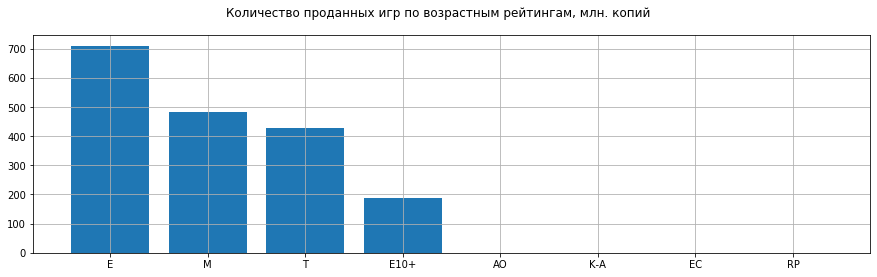

In [74]:
index = rating['rating']
values = rating['eu_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по возрастным рейтингам, млн. копий')
ax.grid()
plt.show()

Мы видим, что топ 3 состоит из тех же возрастных рейтингов, что и Северное Америке с отличием в их положении. Второе место в Европе по количеству проданных игр занимает рейтинг 17+. Не похоже, что возрастной рейтинг существенно влияет на продажи игр.

<a href='#Оглавление'> К оглавлению</a>

<a id='Регион "Япония"'></a>
### 3.3 Регион "Япония"

Проделаем аналогичный набор процедур для Японии.

In [75]:
#соберем таблицу с продажами игр в Японии с разбивкой по платформам
jp_popular_platforms = data.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
#присоединим к ней ранее сформированную таблицу с текущим статусом платформы
jp_popular_platforms = platform_year_check.join(jp_popular_platforms, on='platform')\
[['platform', 'jp_sales', 'platform_success', 'min_year_of_release', 'max_year_of_release']]
#отсортируем значения по убыванию количества проданных копий игр
jp_popular_platforms = jp_popular_platforms.sort_values('jp_sales', ascending=False)
jp_popular_platforms.head()

,platform,jp_sales,platform_success,min_year_of_release,max_year_of_release
12,DS,175.57,Неактуально,2004,2013
11,PS,139.82,Неактуально,1994,2003
5,PS2,139.20,Неактуально,2000,2011
10,SNES,116.55,Неактуально,1990,1999
18,3DS,100.67,Актуально,2011,2016


Мы видим, что в исторической ретроспективе результаты Японии существенно отличаются: 

1. Топ 5 платформ состоит исключительно из японских игровых платформ
2. 3 из 5 платформ принадлежат компании Nintendo
3. Вместо 1 портативной платформы, характерной для Северной Америки и Европы, в Японии в топ по количеству проданных игр входят 2: DS и 3DS

In [76]:
#теперь посмотрим на топ 5 актуальных платформ
jp_popular_platforms.loc[jp_popular_platforms['platform_success'] == 'Актуально'].head()

,platform,jp_sales,platform_success,min_year_of_release,max_year_of_release
18,3DS,100.67,Актуально,2011,2016
19,PSV,21.91,Актуально,2011,2016
23,PS4,15.96,Актуально,2013,2016
20,WiiU,13.01,Актуально,2012,2016
24,XOne,0.34,Актуально,2013,2016


Такая же "специфическая" картина характерна и для топ 5 актуальных платформ: 

1. С огромным отрывом (в 4.6 раза) лидирует портативная игровая платформа Nintendo 3DS (она же присутствует в топе популярных актуальных платформ и в других регионах 4 и 3 места в Северной Америке и Европе соответственно)
2. Второе место занимает другая портативная платформа - Playstation Vita, которой нет в топ 5 актуальных платформ ни в одном другом регионе 
3. Закономерно, что PS4 и в этом топе показывает неплохой результат, уступив примерно четверть по количеству проданных игр платформе PSV (ранее мы уже установили, что это практически абсолютный лидер текущего поколения) 
4. Любопытно, что в числе современных платформ в Японии хоть и есть американский XOne, но на пятом месте, а от продаж 4 места (WiiU) она занимает около 2.6% - не "отечественные" платформы на этом рынке явно не очень востребованы.

In [77]:
jp_popular_genres = data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_popular_genres.head()
#получаем top 5 популярных жанров в регионе

,jp_sales
genre,
Role-Playing,355.41
Action,161.43
Sports,135.54
Platform,130.83
Misc,108.11


На фоне существенно отличающейся картины по спросу на игры в разрезе платформ, значительно отличаются и популярные жанры: 

1. Мы видим, что первую строчку с отрывом более чем в два раза занимает жанр RPG, которого просто не было в топах популярных игр в Европе и Северной Америке
2. Также в топ вошли платформеры, которых тоже не было в Европе (но были в Северной Америке)

Анализ структуры популярности жанров в разрезе плафтформ, который мы провели ранее, позволяет нам предположить, что наличие/отсутствие этих жанров обусловлено уровнем популярности игровых платформ Nintendo. 

In [78]:
jp_genre_sep = data.pivot_table(index='platform', columns='genre', values='jp_sales', aggfunc='sum')
jp_popular_platforms = jp_popular_platforms.join(jp_genre_sep, on='platform')
jp_popular_platforms.loc[jp_popular_platforms['platform_success'] == 'Актуально'].head()

,platform,jp_sales,platform_success,min_year_of_release,max_year_of_release,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
18,3DS,100.67,Актуально,2011,2016,22.66,2.76,3.22,5.51,6.48,1.80,2.83,41.99,0.20,10.39,1.98,0.85
19,PSV,21.91,Актуально,2011,2016,6.84,2.33,0.68,2.31,0.06,0.05,0.16,7.85,0.24,0.07,1.05,0.27
23,PS4,15.96,Актуально,2013,2016,5.90,0.45,0.75,0.42,0.49,0.00,0.26,3.55,2.81,0.18,0.99,0.16
20,WiiU,13.01,Актуально,2012,2016,1.09,0.00,1.01,2.45,3.68,0.22,1.30,0.89,1.54,0.00,0.52,0.31
24,XOne,0.34,Актуально,2013,2016,0.05,0.03,0.01,0.01,0.00,NaN,0.05,0.01,0.16,0.00,0.02,0.00


Так как в топе популярных платформ в Японии отсутствует PC, структура жанров на популярных платформах в Японии не удивляет - она похожа на топ популярных жанров.

In [79]:
rating = data.pivot_table(index='rating', values='jp_sales', aggfunc='sum').reset_index()\
.sort_values('jp_sales', ascending=False)
rating

,rating,jp_sales
1,E,198.11
7,T,151.40
5,M,64.24
2,E10+,40.20
4,K-A,1.46
0,AO,0.00
3,EC,0.00
6,RP,0.00


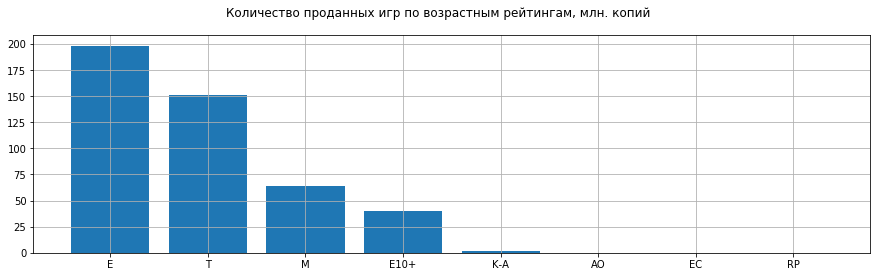

In [80]:
index = rating['rating']
values = rating['jp_sales']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(15)
fig.suptitle('Количество проданных игр по возрастным рейтингам, млн. копий')
ax.grid()
plt.show()

По распределению количества проданных игр по жанрам похожа на Северную Америку с одним существенным отличием - М (17+) практически вдвое уступает по количеству проданных копий. Вероятно, спрос на консоли Nintendo с этим связан.

<a href='#Оглавление'> К оглавлению</a>

<a id='Проверка гипотез'></a>
## 4. Проверка гипотез

<a id='Средние пользовательские рейтинги платформ Xbox One и PC одинаковые'></a>
### 4.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Средние пользовательские рейтинги платформ Xbox One и PC одинаковы**
- **Альтернативная гипотеза (H₀): Средние пользовательские рейтинги платформ Xbox One и PC различаются**

Для проверки используем максимально высокий критерий статистической значимости, предполагая, что размер выборки может дать несколько искаженные данные. 

In [81]:
#сформируем два ряда данных с пользовательскими оценками в виде series
xone_score = data.loc[(data['platform'] == 'XOne') & (data['user_score'] > 0), 'user_score']
pc_score = data.loc[(data['platform'] == 'PC') & (data['user_score'] > 0), 'user_score']

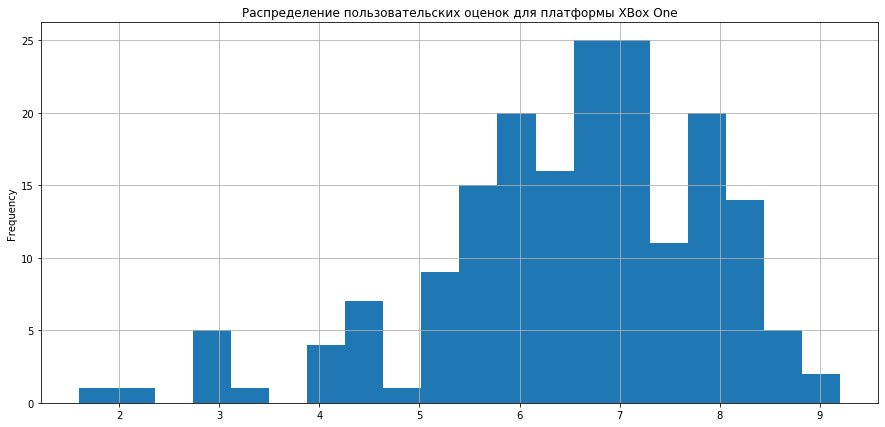

In [82]:
xone_score.plot(kind='hist', bins=20, figsize=(15, 7), grid=True,\
                                                        title='Распределение пользовательских оценок для платформы XBox One')

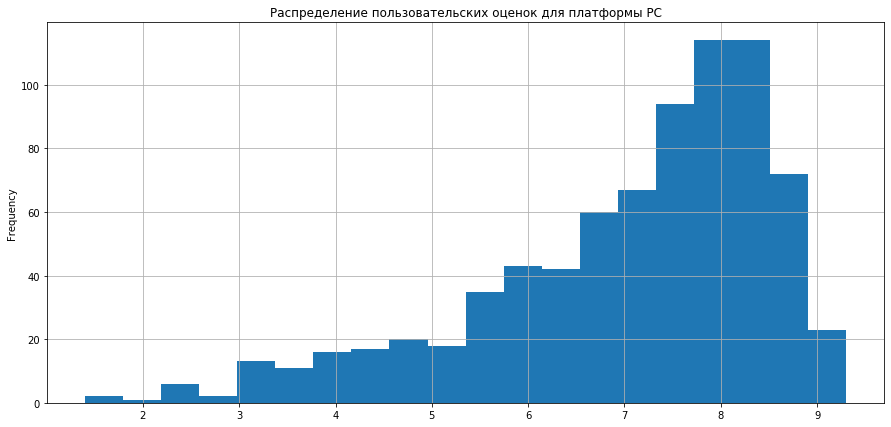

In [83]:
pc_score.plot(kind='hist', bins=20, figsize=(15, 7), grid=True,\
                                                        title='Распределение пользовательских оценок для платформы PC')

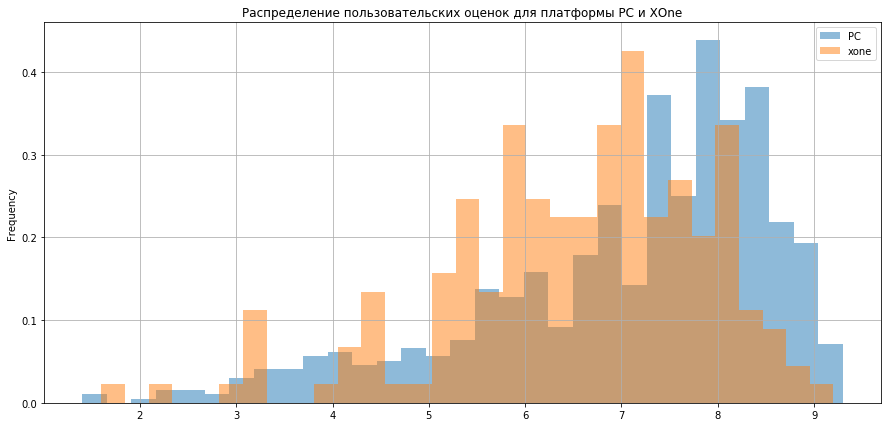

In [84]:
plt.title('Распределение пользовательских оценок для платформы PC и XOne')
pc_score.plot(kind='hist', bins=31, 
              figsize=(15, 7), grid=True,
             label='PC', density=True, alpha=0.5)
xone_score.plot(kind='hist', bins=31, 
                figsize=(15, 7), grid=True,
               label='xone', density=True, alpha=0.5)
plt.legend()
plt.show()

<hr style="border: 2px solid orange;" />

Судя по гистограммам, распределение пользовательских оценок для каждого не очень похоже на идеальное распределение, но стремится к нему.

In [85]:
xone_score.describe()

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

In [86]:
pc_score.describe()

count    770.000000
mean       7.062468
std        1.529963
min        1.400000
25%        6.200000
50%        7.500000
75%        8.200000
max        9.300000
Name: user_score, dtype: float64

Учитывая логику, по которой сформированы оценки: 

1. Мы работаем с количественными данными (так как каждая оценка является средним от множества дискретных оценок, она может принять любое значение со сколь угодно большим числом знаков после точки)
2. Предполагаем, что данные подчиняются закону нормального распределения
3. Так как мы работаем с пользовательскими оценками на двух разных платформах, мы предполагаем, что эти группы независимы друг от друга 
4. Мы сравниваем две группы 

Следовательно, будем использовать Т-тест с параметром `equal_var=False` для проведения теста Уэлча, так как мы предполагаем разность дисперсий для двух выборок (мы видим и в описании рядов и на гистограммах, что это вероятней всего так).

Для теста используем довольно "свободный" уровень значимости в 10%.

In [87]:
alpha = 0.1 #зададим критический уровень статистической значимости в 10%

results = stats.ttest_ind(
    xone_score, 
    pc_score,
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.935072360183565e-06
Отвергаем нулевую гипотезу


Наши данные противоречат предположению о том, что средние пользовательские оценки на этих двух платформах одинаковы. 

<a href='#Оглавление'> К оглавлению</a>

<a id='Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные'></a>
### 4.2 Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Средние пользовательские рейтинги жанров Action и Sports одинаковы**
- **Альтернативная гипотеза (H₀): Средние пользовательские рейтинги жанров Action и Sports различаются**

Для проверки используем максимально высокий критерий статистической значимости, предполагая, что размер выборки может дать несколько искаженные данные. 

In [88]:
action_genre_user_score = data.loc[(data['genre'] == 'Action') & (data['user_score'] > 0), 'user_score']
sports_genre_user_score = data.loc[(data['genre'] == 'Sports') & (data['user_score'] > 0), 'user_score']

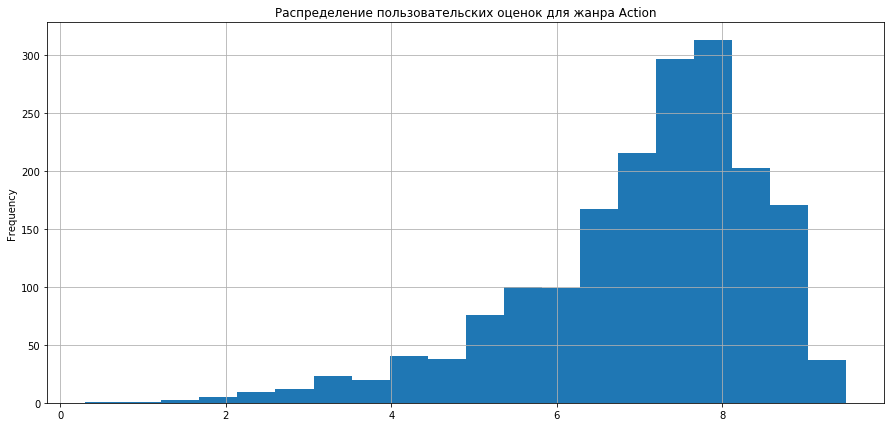

In [89]:
action_genre_user_score.plot(kind='hist', bins=20, figsize=(15, 7), grid=True,\
                                                        title='Распределение пользовательских оценок для жанра Action')

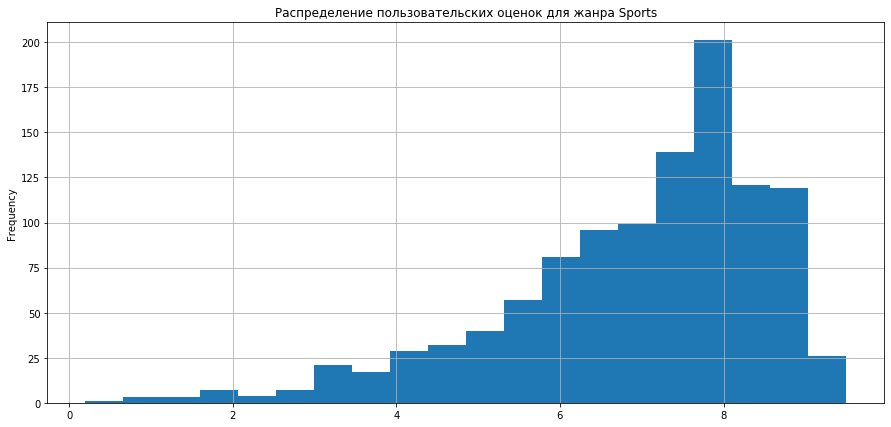

In [90]:
sports_genre_user_score.plot(kind='hist', bins=20, figsize=(15, 7), grid=True,\
                                                        title='Распределение пользовательских оценок для жанра Sports')

In [91]:
action_genre_user_score.describe()

count    1830.000000
mean        7.054044
std         1.425394
min         0.300000
25%         6.300000
50%         7.400000
75%         8.100000
max         9.500000
Name: user_score, dtype: float64

In [92]:
sports_genre_user_score.describe()

count    1103.000000
mean        6.961197
std         1.611370
min         0.200000
25%         6.100000
50%         7.400000
75%         8.100000
max         9.500000
Name: user_score, dtype: float64

Так как два этих ряда похожи по типу на данные из пункта выше, применим Т-тест по Уэлчу (по аналогии) с "строгим" уровнем значимости в 1%.

In [93]:
alpha = 0.01 #зададим критический уровень статистической значимости в 1%

results = stats.ttest_ind(
    action_genre_user_score, 
    sports_genre_user_score,
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.11483818791498286
Не получилось отвергнуть нулевую гипотезу


С вероятность около 11.5% разность между средними оценками двух игр может быть случайной, поэтому мы не можем отвергнуть нулевую гипотезу - наши данные ей не противоречат.

<a href='#Оглавление'> К оглавлению</a>

In [40]:
def convergence(n):
    test_series = []
    base_series = []
    base_number = 1
    while n not in base_series:
        for t_number in test_series: 
            if t_number in base_series:
                return(test_series.index(t_number))
        if n / 10 < 1:
            test_series.append(n)
            n += n
        else: 
            test_series.append(n)
            multiplied_number = 1
            for digit in str(n):
                if int(digit) != 0:
                    multiplied_number = multiplied_number * int(digit)
            n += multiplied_number
        if base_number / 10 < 1:
            base_series.append(base_number)
            base_number += base_number
        else:
            base_series.append(base_number)
            multiplied_number = 1
            for digit in str(base_number):
                if int(digit) != 0:
                    multiplied_number = multiplied_number * int(digit)
            base_number += multiplied_number

In [44]:
convergence(5)

6

<a id='Выводы'></a>
## 5. Выводы

<span style="text-decoration:underline">По результатам анализа датасета о продажах игр мы можем сформулировать следующие выводы:</span>

1. По результатам анализа общего и "активного" жизненного цикла разных платформ можно выделить 6 "актуальных":
    + PC
    + 3DS
    + PSV
    + WiiU
    + PS4
    + XOne
2. Среди "актуальных" платформ можно выделить две условных группы:
    + Группа 1 - максимально перспективные: 
        - PC - платформа-"исключение", так как не делится на четкие поколения, поэтому ее можно рассматривать как актуальную на текущий момент
        - PS4 - текущий срок жизни и "активный" срок жизни равны ("активный" срок меньше среднего значения) = платформа "свежая" и тайтлы для нее активно продаются
        - XOne - аналогично PS4
    + Группа 2 - умеренно перспективные: 
        - 3DS - срок "активного" жизненного цикла равен среднему значению и меньше общего срока жизни - вероятно, продажи пересекли рубеж снижения. Кроме того, консоль имеет характерную особенность - она портативная, что тоже может влиять на специфику спроса
        - PSV - аналогично 3DS, за исключеним величины "активного" срока жизни, но он все же попадает в диапазон 3-5 лет, хоть и меньше средних 4 лет
        - WiiU - срок "активного" жизненного цикла меньше общего срока жизни
3. Выявлены наиболее популярные жанры в целом по миру на всех платформах: 
    + Shooter 
    + Platform
    + Role-Playing
    + Sports 
    + Racing
4. Выявлено также, что одна из популярных платформ (PC) имеет другую структуру популярных жанров, вероятно обусловленных особенностями взаимодействия пользователя с системой:
    + Simulation
    + Strategy
    + Shooter 
    + Role-Playing
    + Action
5. Также установлено, что регион Япония значительно отличается как в части списка популярных платформ, так и в части популярных жанров:
    + Популярные в Японии платформы: 
        - 3DS
        - PSV
        - PS4
        - WiiU
        - XOne (данную платформу можно было бы исключить по причине исчезающе малого количества проданных игр относительно остальных 4 платформ)
    + Популярные в Японии жанры: 
        - Role-Playing (данный жанр требует анализа - наиболее вероятно, перечень тайтлов значительно отличается от игр этого же жанра, популярных в Европе или Северной Америке)
        - Action
        - Sports
        - Platform
        - Misc
6. Регионы Европа и Северная Америка похожи по спросу на стационарные консоли, однако в Северной Америке в большей степени популярны консоли Nintendo, а в Европе, в свою очередь, больше ниша у ПК
7. Установлено, что корреляция между оценками критиков и продажами игр составляет порядка 40% - таким образом, мы можем говорить о влиянии оценок критиков на продажи. В то же время, корреляция между оценками пользователей и продажами нестабильна - иногда наблюдается тенденция на изменение ее направления. 
8. Установлено, что некоторые тайтлы могут иметь обратно пропорциональные оценки критиков и пользователей
9. Установлено, что средний срок жизни платформы - 9 лет, а "активный" срок жизни около 4 лет. 